# Introduction

## 1. Project goals

The goal of this project is to develop a reproducible machine learning pipeline to accurately predict loan default risks using a real-world dataset from a German bank. The final report aims to be comprehensive, well-documented, and potentially publishable.

## 2. Data acquisition

The dataset, provided as German_bank.csv, contains 17 features and 1,000 customer records, encompassing various aspects such as credit history, employment duration, and loan amount.

## 3. Model development

We will employ base models, apply penalty functions, and utilize ensemble methods. Additionally, hyperparameter tuning and anomaly detection techniques will be integrated to optimize model performance and robustness. The model development was also implemented after upsampling the data, which, while improving performance, may introduce the risk of data leakage.

# Loading libraries and Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             RocCurveDisplay,
                             precision_recall_curve,
                             average_precision_score,
                             roc_auc_score,
                             roc_curve, auc,
                             classification_report,
                             confusion_matrix)
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df=pd.read_csv('credit.csv')

# Understanding the data: Exploratory Data Analysis [EDA]

In [ ]:
df.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [ ]:
numerical_features = ['months_loan_duration', 'amount', 'percent_of_income', 'years_at_residence', 'age','existing_loans_count','dependents']

categorical_features = ['checking_balance', 'credit_history', 'purpose', 'savings_balance',
                        'employment_duration', 'other_credit', 'housing', 'job', 'phone']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

In [ ]:
for column in df.columns:
    if column not in ('amount', 'age','months_loan_duration'):
        print(f"Unique values in '{column}': {df[column].unique()}")

Unique values in 'checking_balance': ['< 0 DM' '1 - 200 DM' 'unknown' '> 200 DM']
Unique values in 'credit_history': ['critical' 'good' 'poor' 'perfect' 'very good']
Unique values in 'purpose': ['furniture/appliances' 'education' 'car' 'business' 'renovations' 'car0']
Unique values in 'savings_balance': ['unknown' '< 100 DM' '500 - 1000 DM' '> 1000 DM' '100 - 500 DM']
Unique values in 'employment_duration': ['> 7 years' '1 - 4 years' '4 - 7 years' 'unemployed' '< 1 year']
Unique values in 'percent_of_income': [4 2 3 1]
Unique values in 'years_at_residence': [4 2 3 1]
Unique values in 'other_credit': ['none' 'bank' 'store']
Unique values in 'housing': ['own' 'other' 'rent']
Unique values in 'existing_loans_count': [2 1 3 4]
Unique values in 'job': ['skilled' 'unskilled' 'management' 'unemployed']
Unique values in 'dependents': [1 2]
Unique values in 'phone': ['yes' 'no']
Unique values in 'default': ['no' 'yes']


In [ ]:
for feature in categorical_features:
    print(df[feature].value_counts())
    print("~"*50)

checking_balance
unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
credit_history
good         530
critical     293
poor          88
very good     49
perfect       40
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
purpose
furniture/appliances    473
car                     337
business                 97
education                59
renovations              22
car0                     12
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
savings_balance
< 100 DM         603
unknown          183
100 - 500 DM     103
500 - 1000 DM     63
> 1000 DM         48
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
employment_duration
1 - 4 years    339
> 7 years      253
4 - 7 years    174
< 1 year       172
unemployed      62
Name: count, dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
other_credit
n

In [ ]:
df['default'].value_counts()

,count
default,
no,700
yes,300


# Visualisation

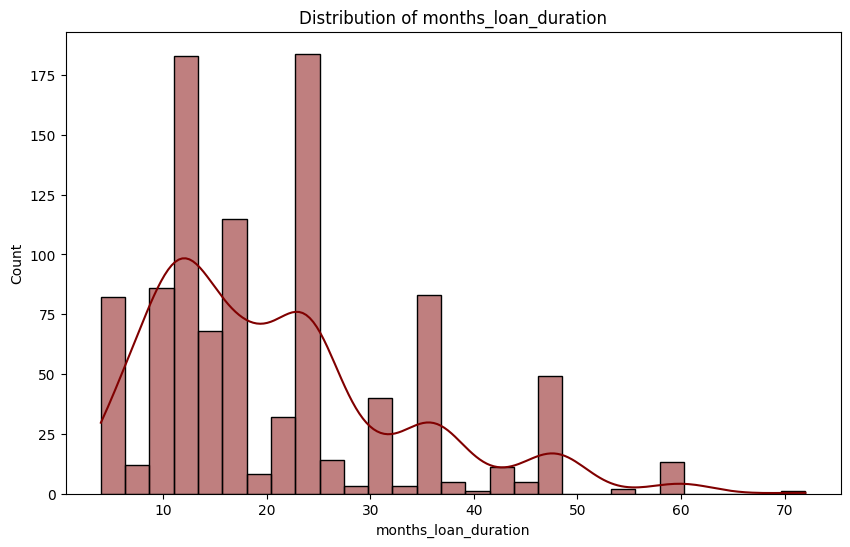

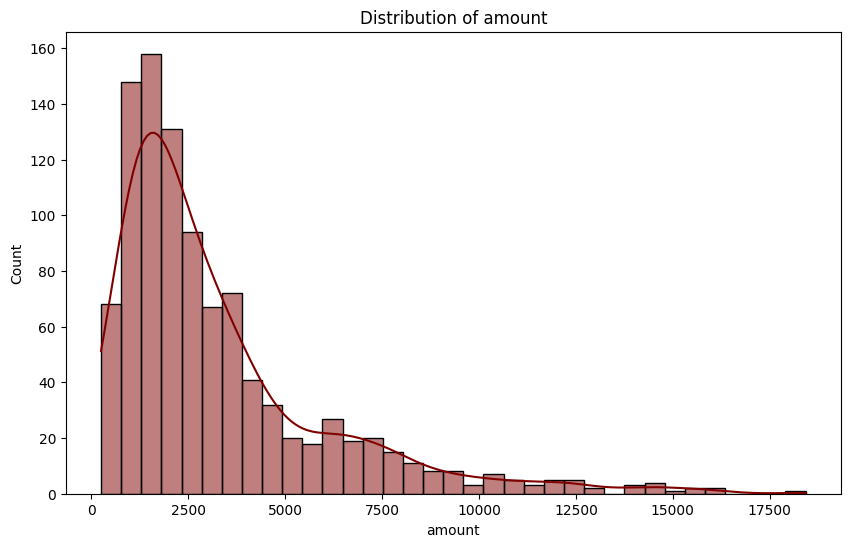

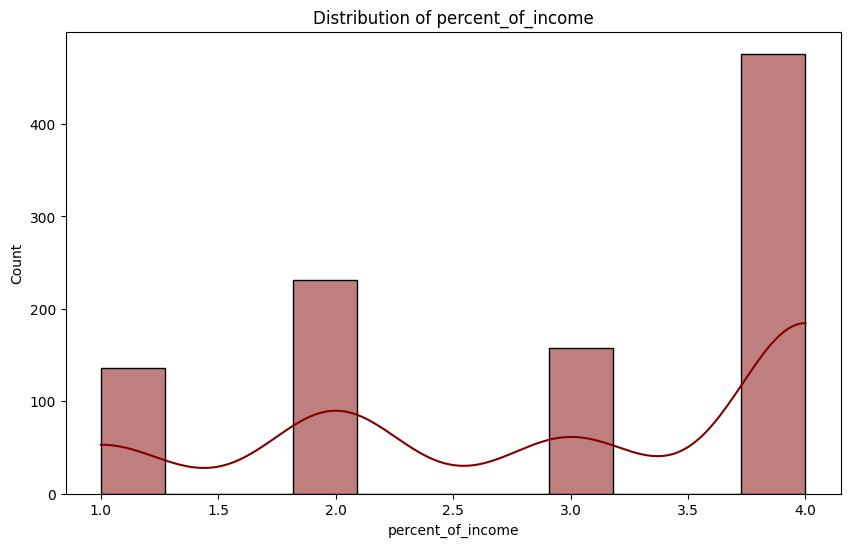

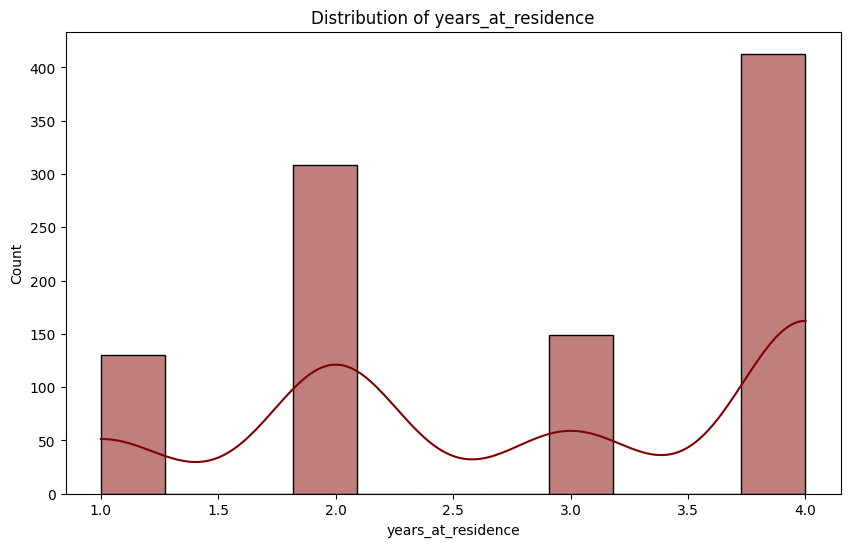

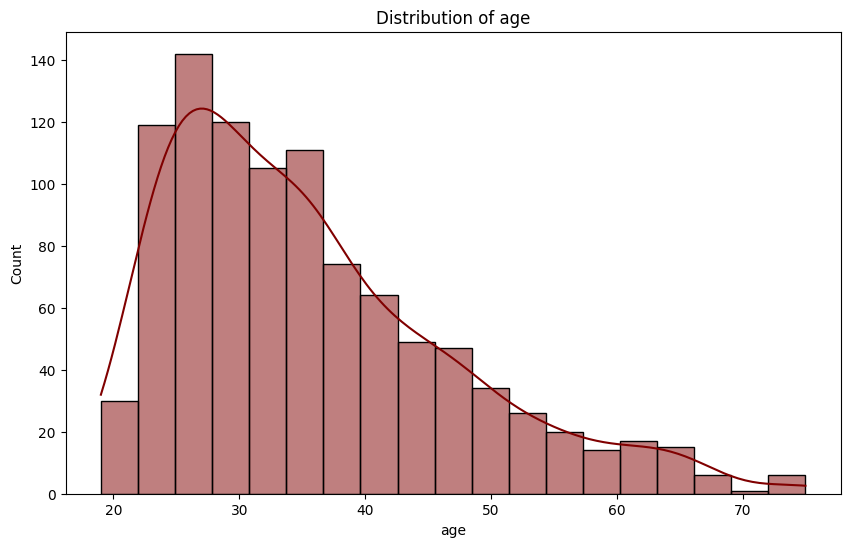

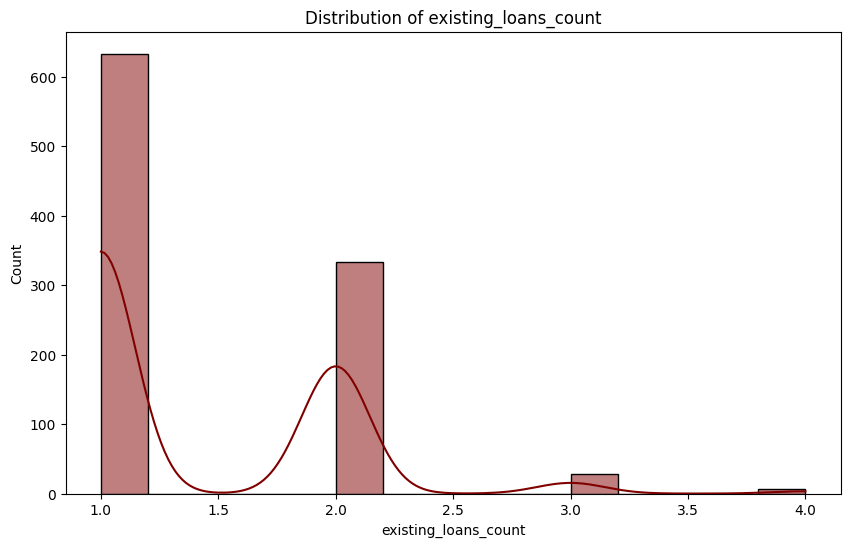

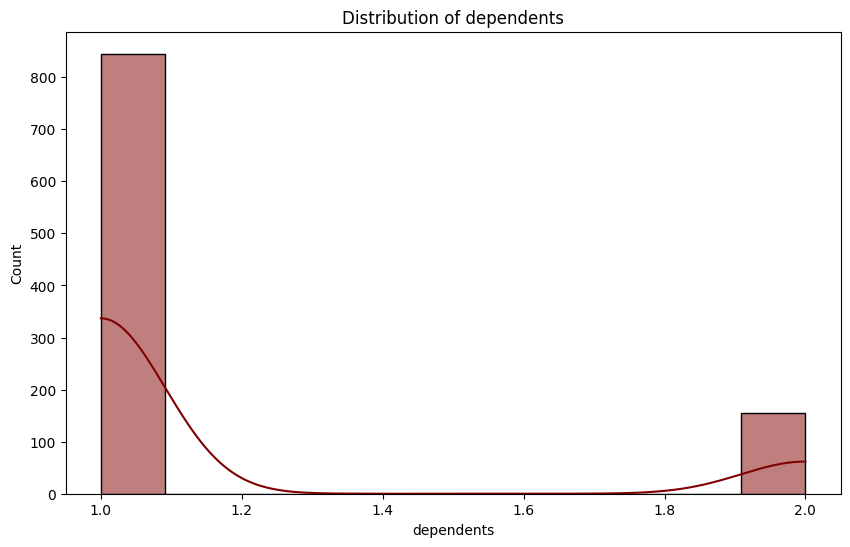

In [ ]:
# KDE + Histogram for each numerical feature
i=1
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, color='maroon')
    plt.title(f'Distribution of {feature}')
    plt.savefig(f'numericalkde{i}.png',dpi=300)
    plt.show()
    i+=1

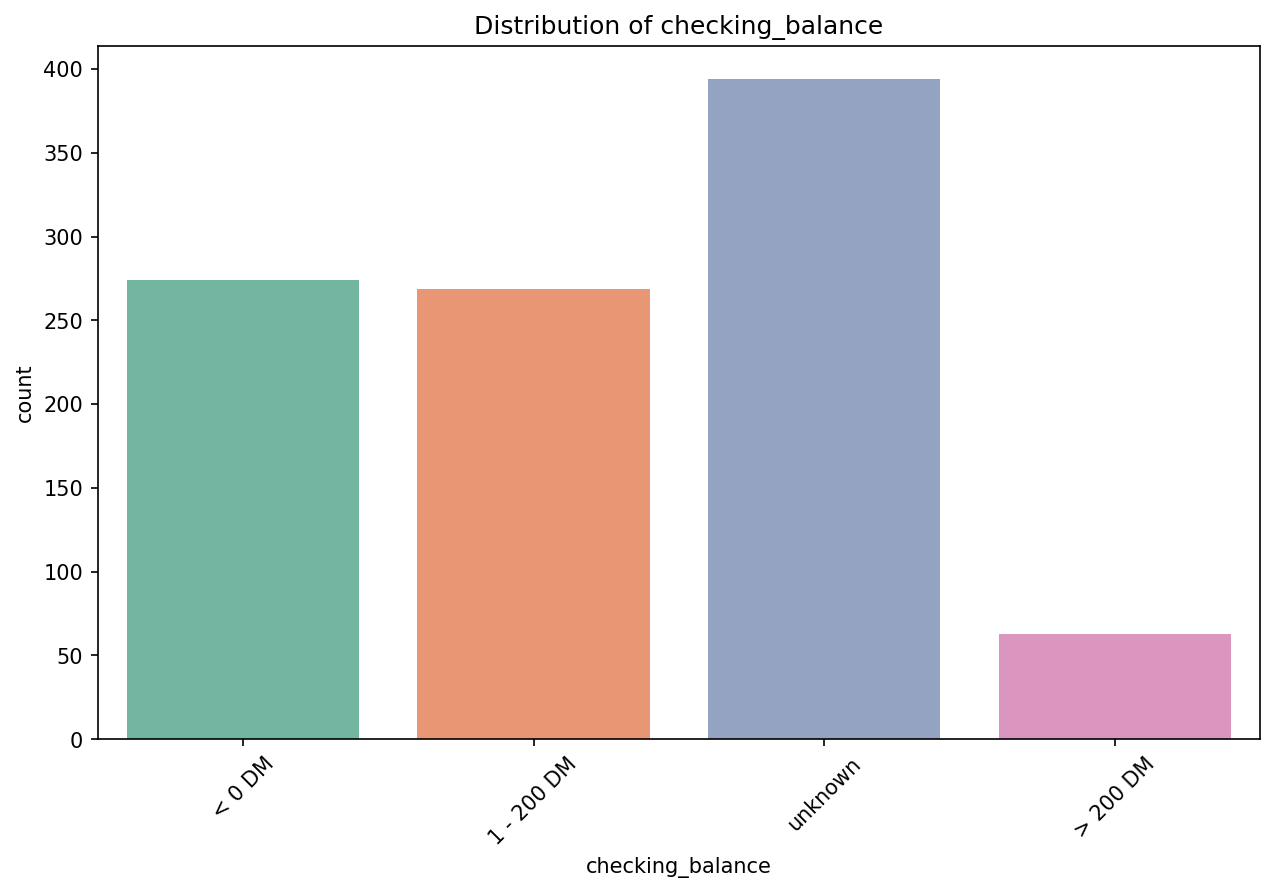

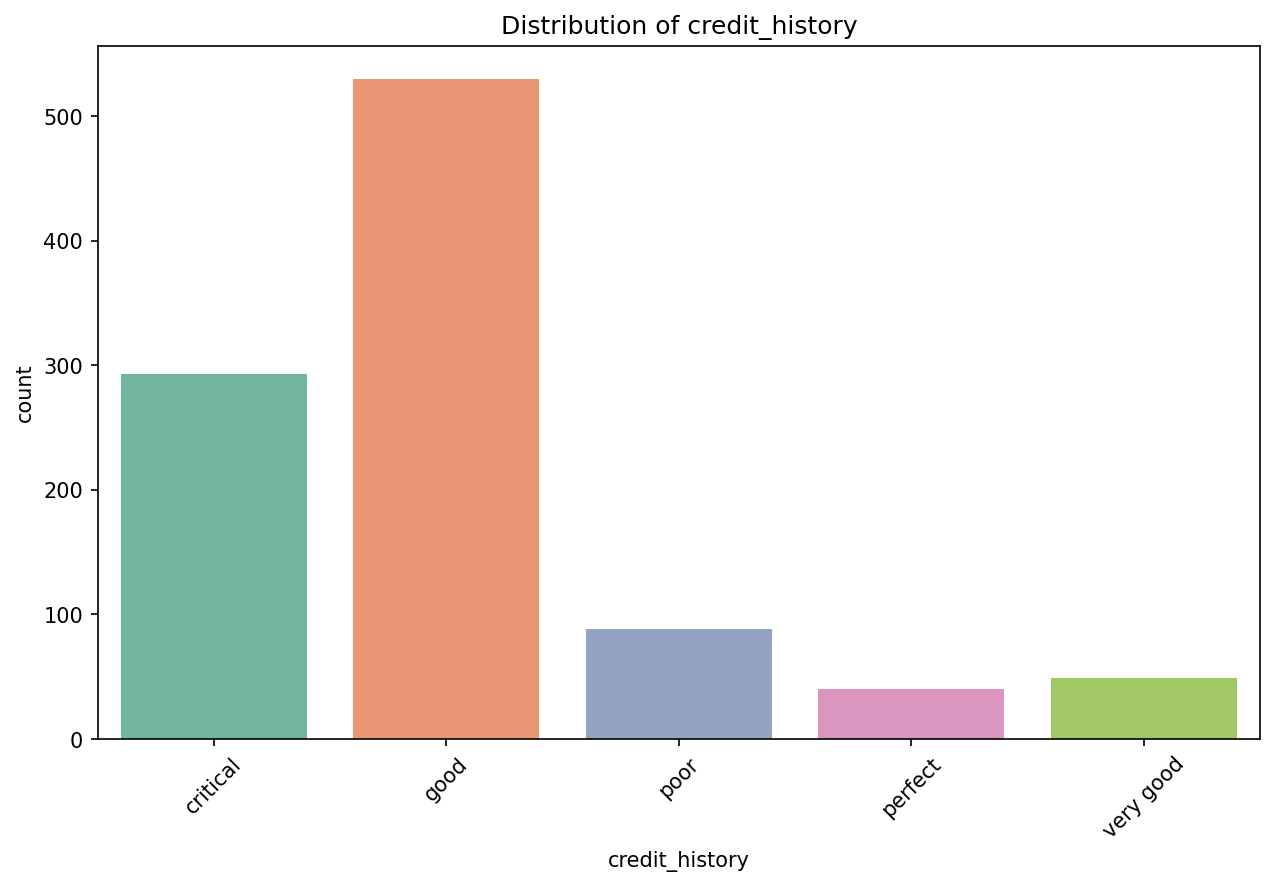

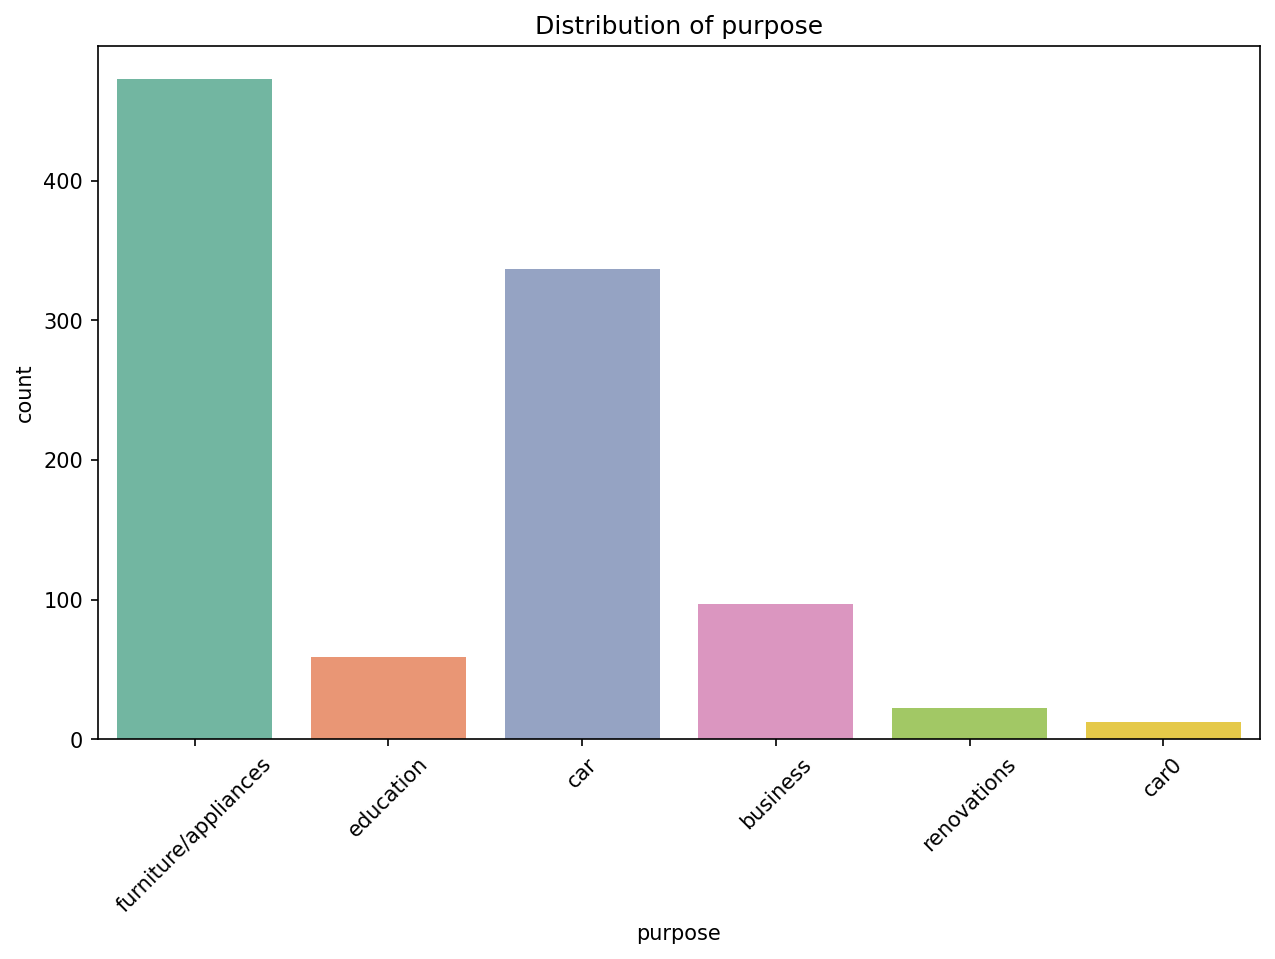

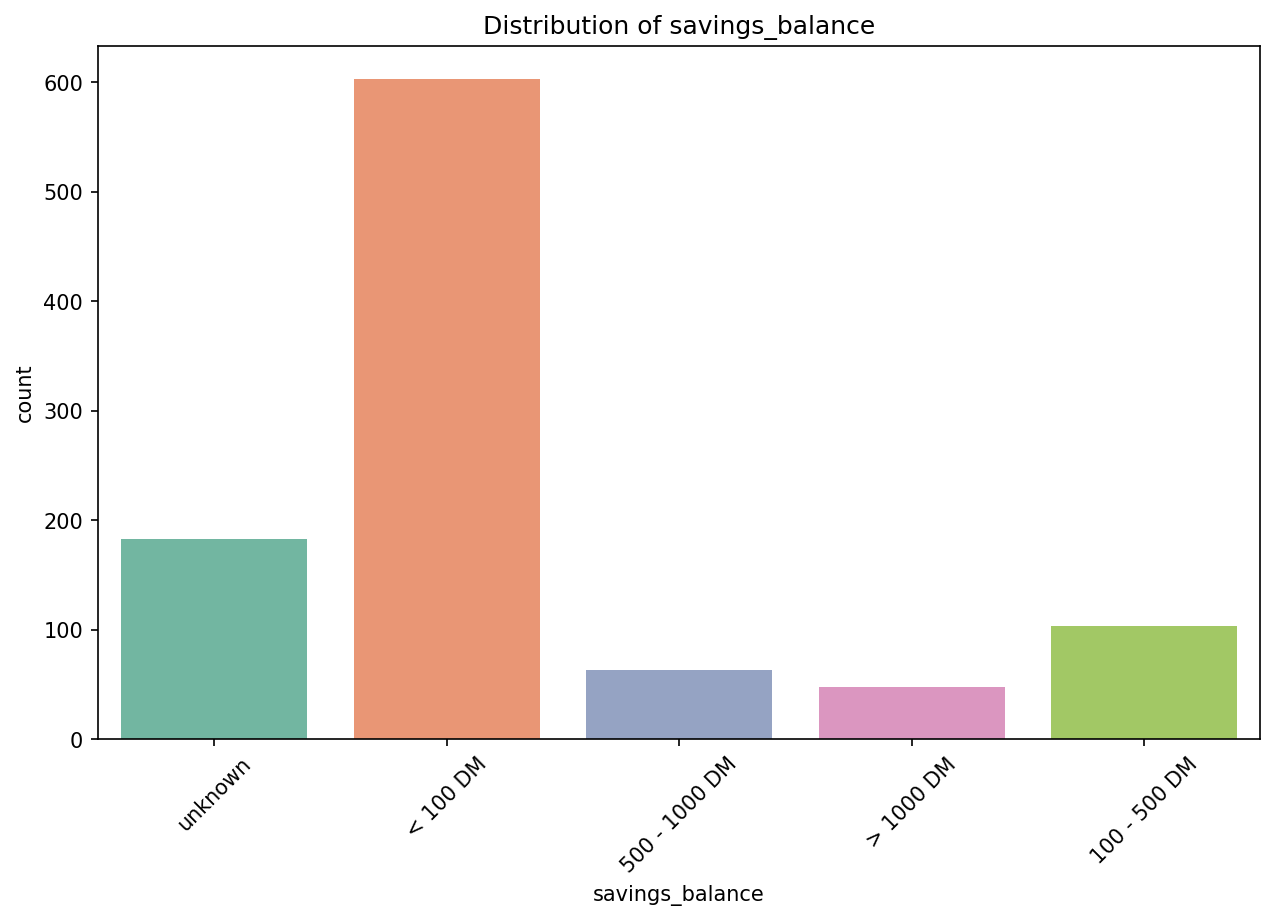

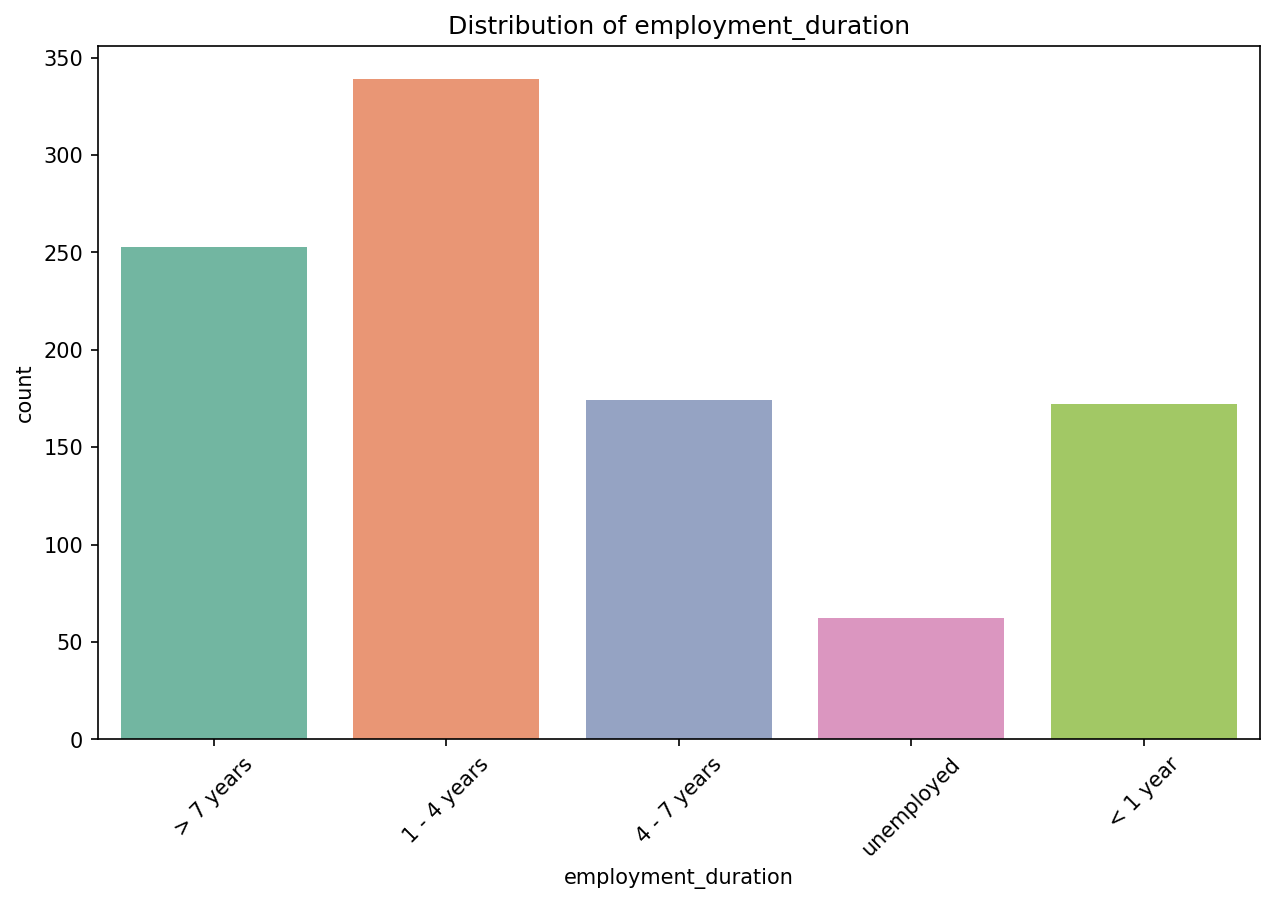

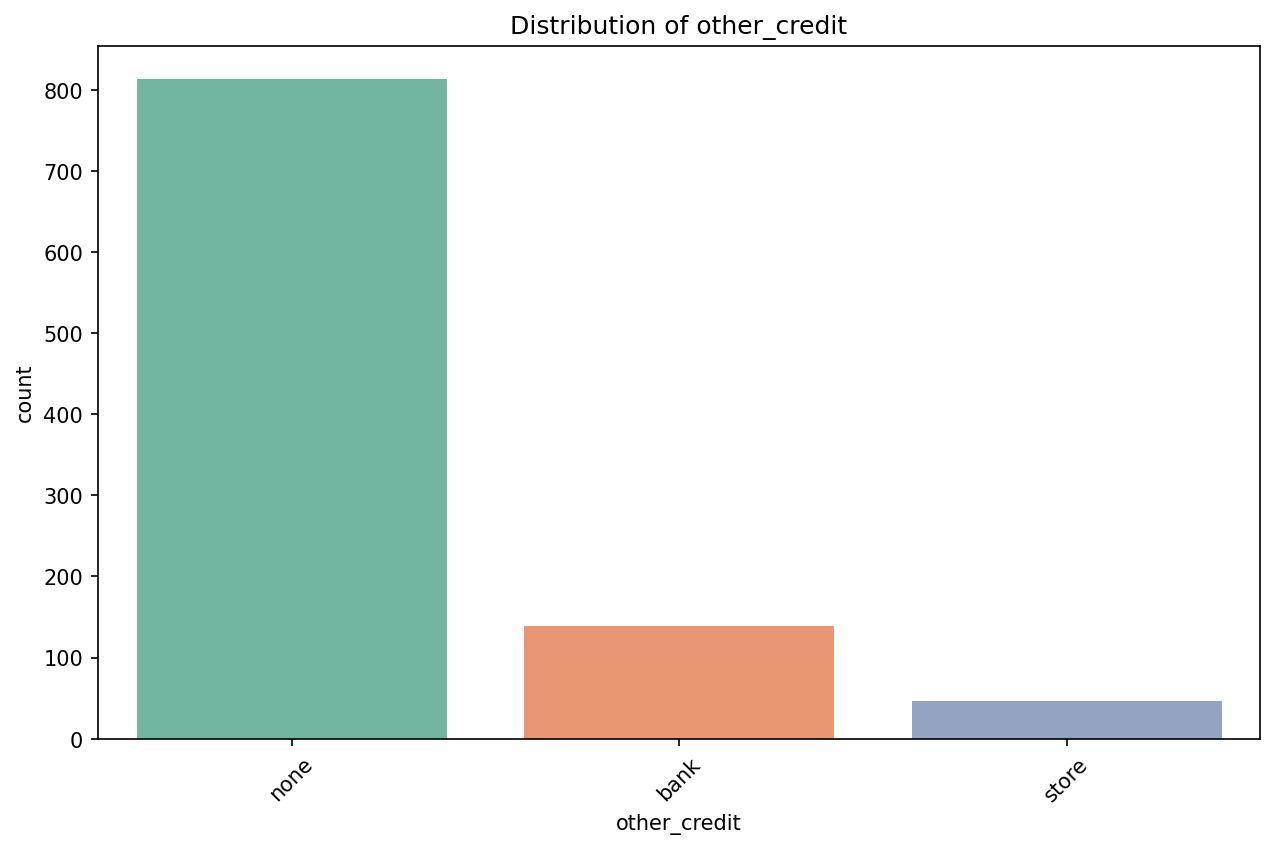

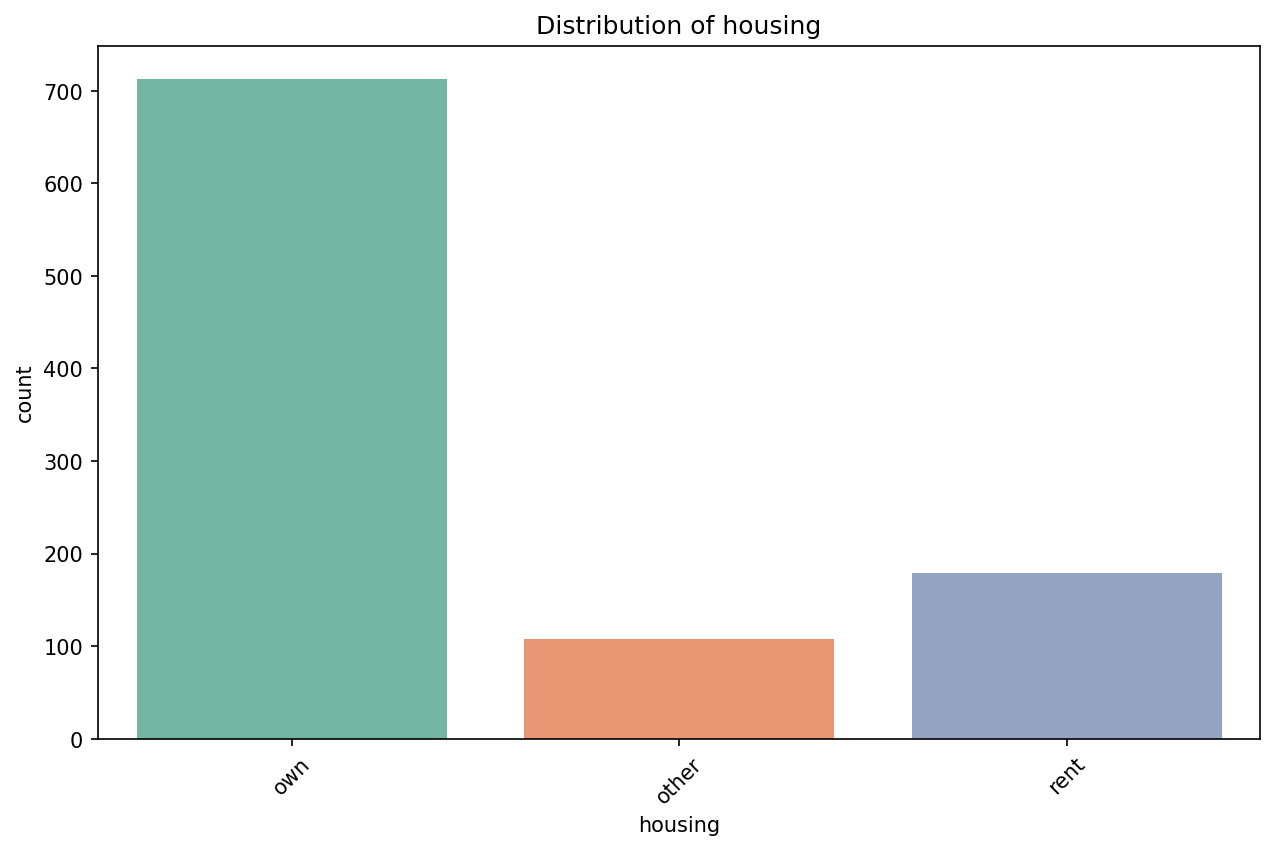

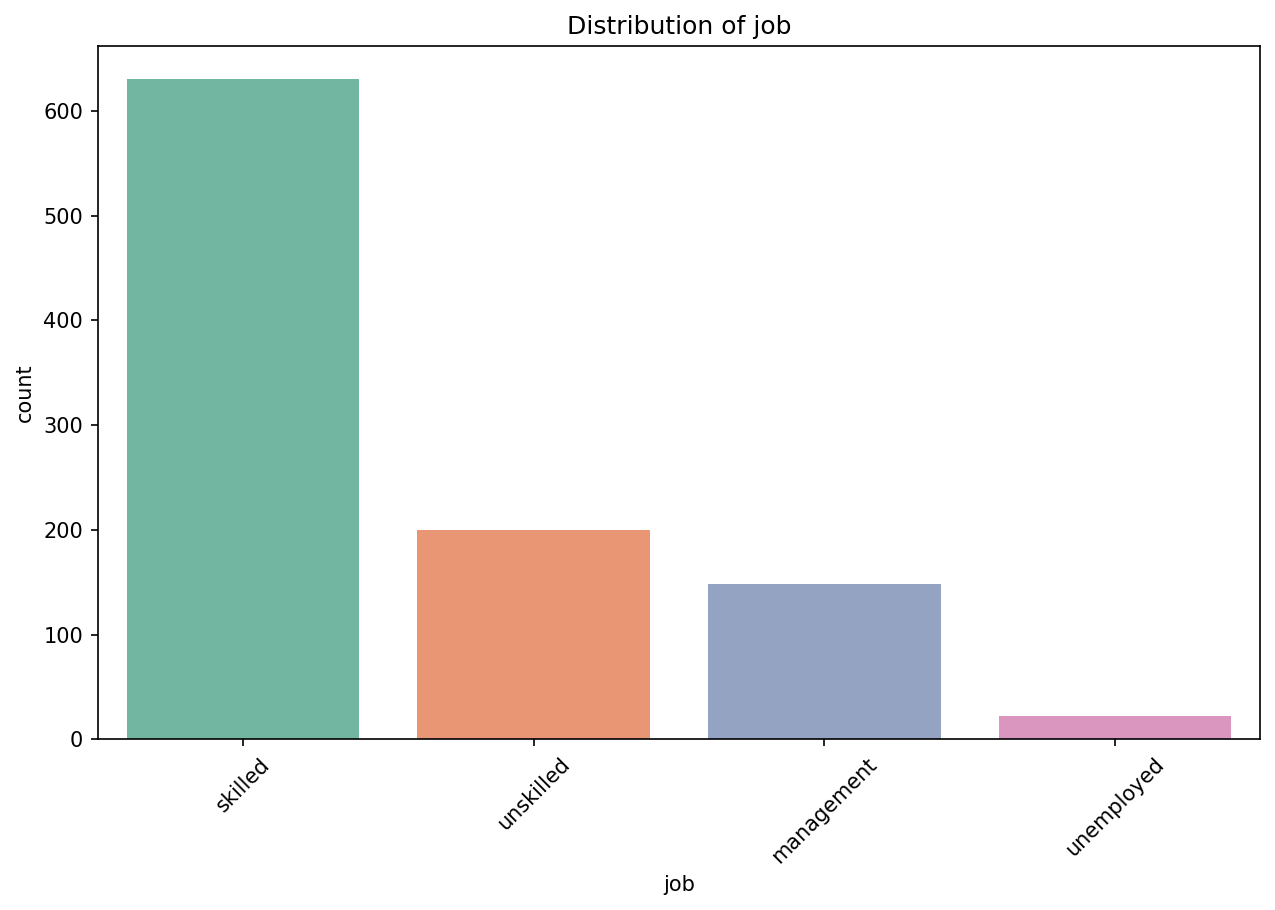

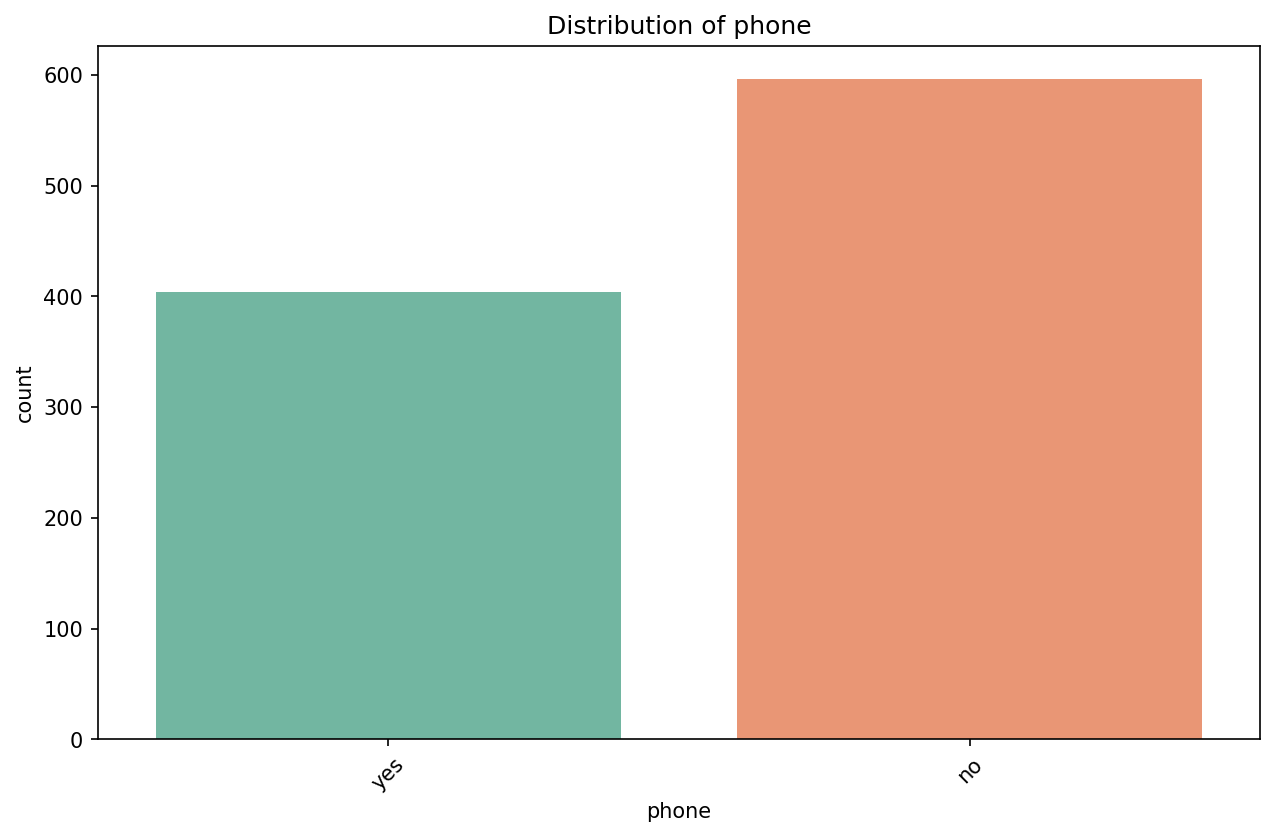

In [ ]:
# Bar plots for each categorical feature
i=1
for feature in categorical_features:
    plt.figure(figsize=(10, 6), dpi=150)
    sns.countplot(data=df, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.savefig(f'categoricalbar{i}.png',dpi=300)
    plt.show()
    i+=1

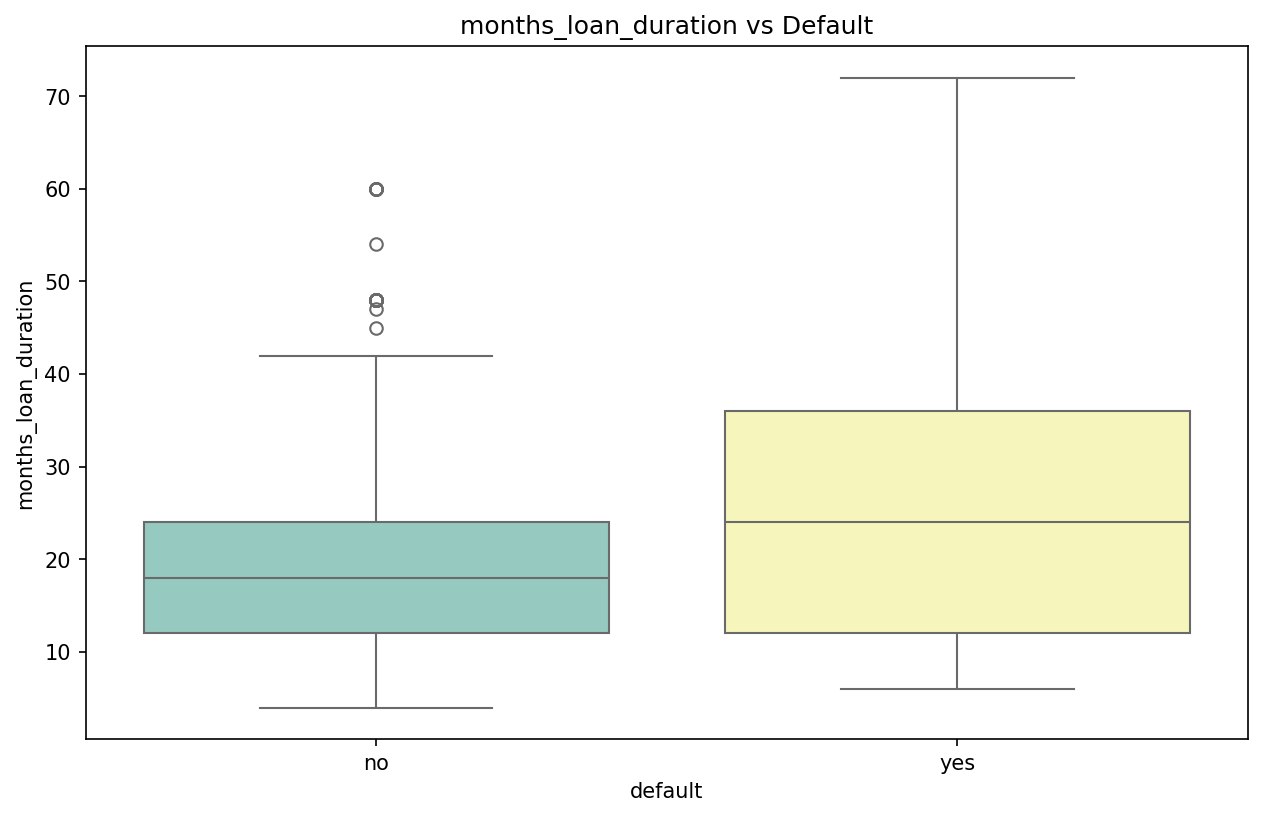

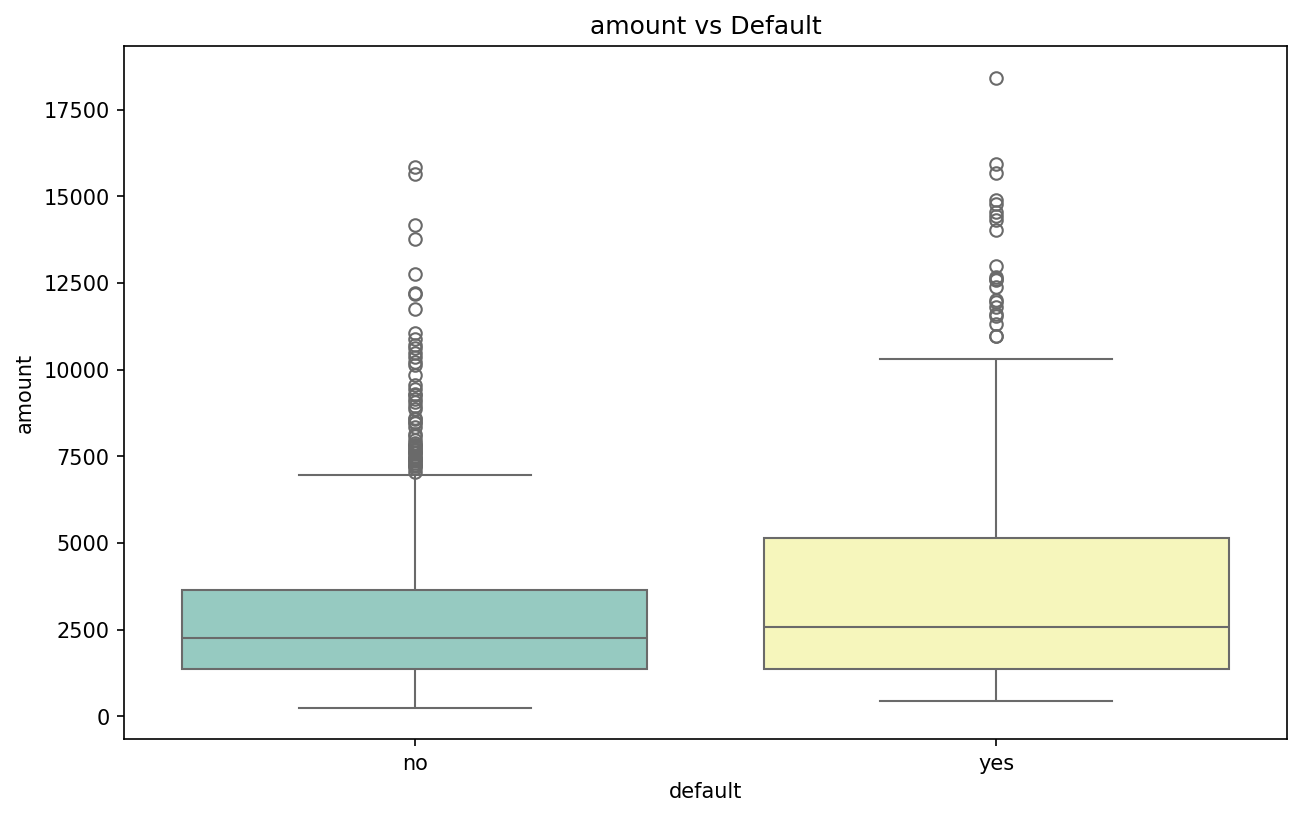

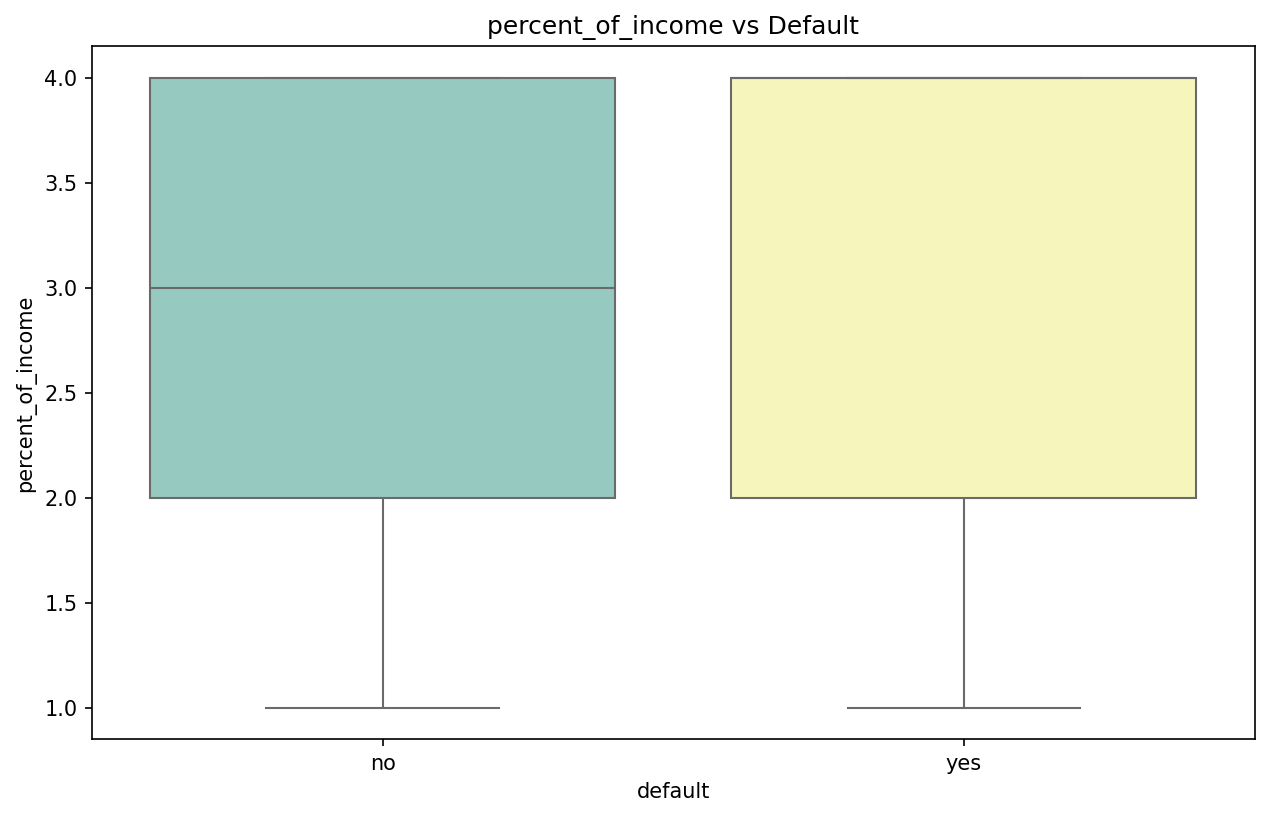

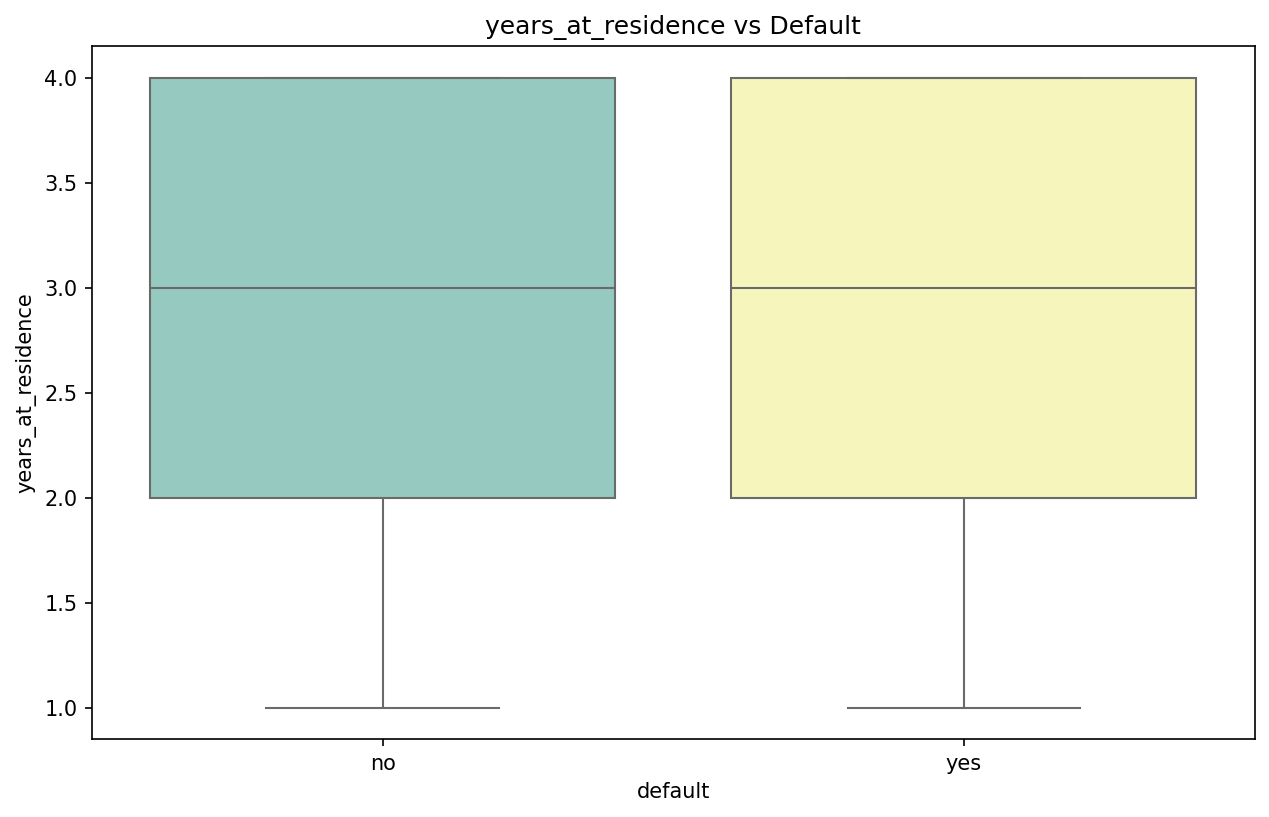

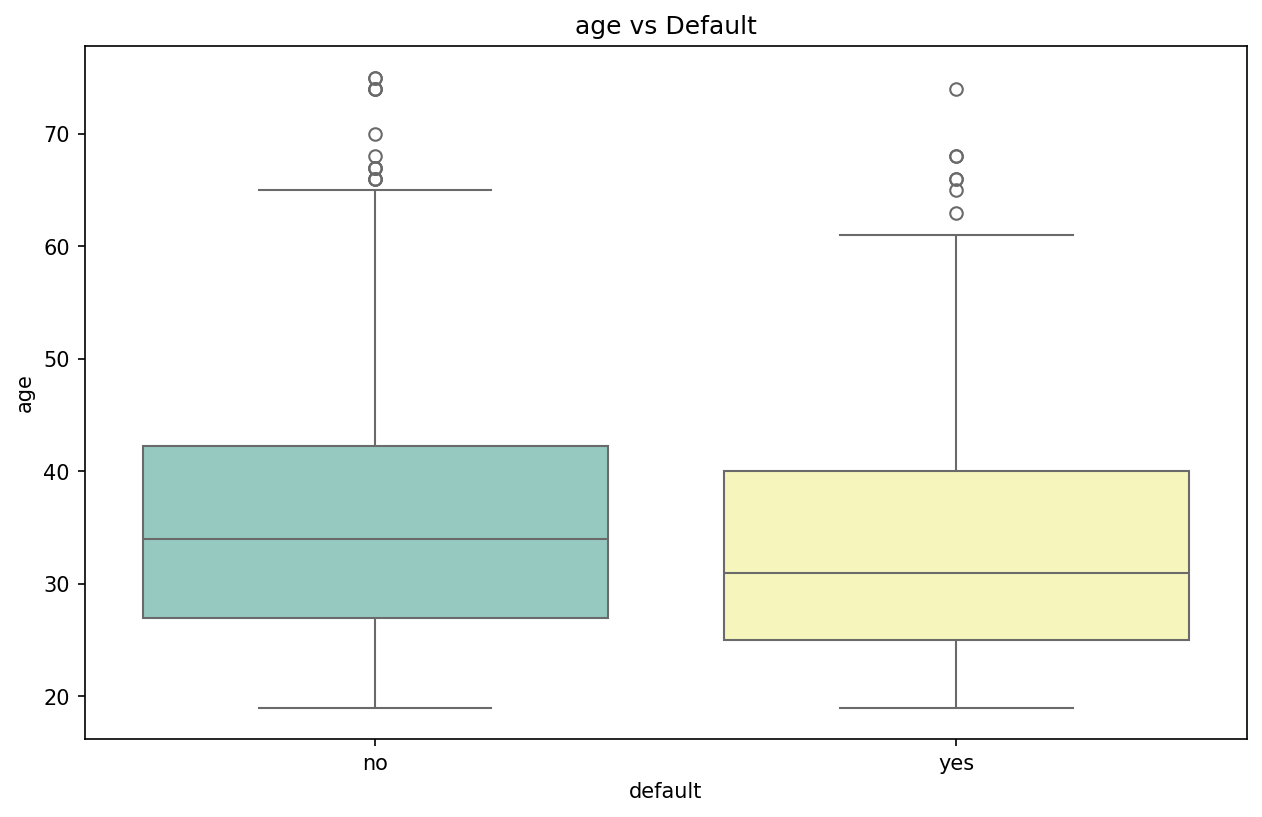

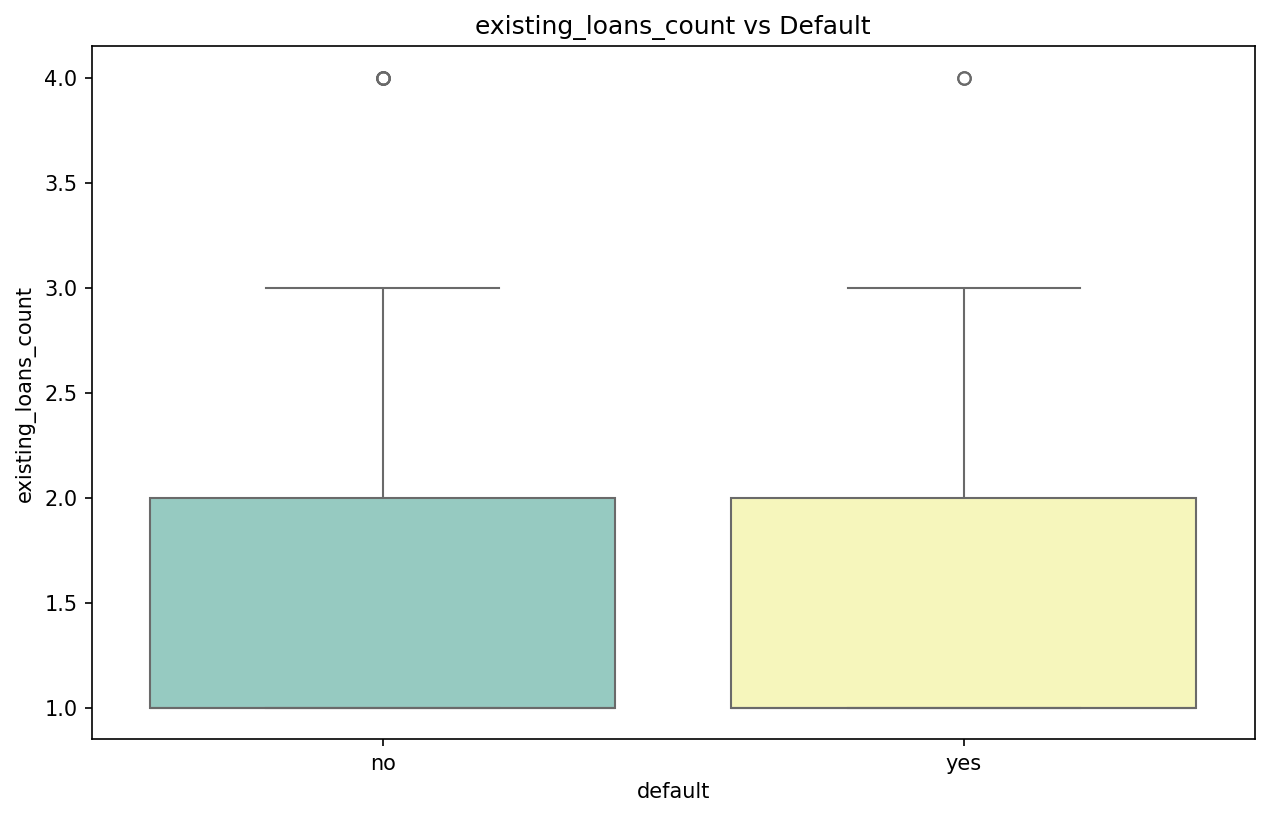

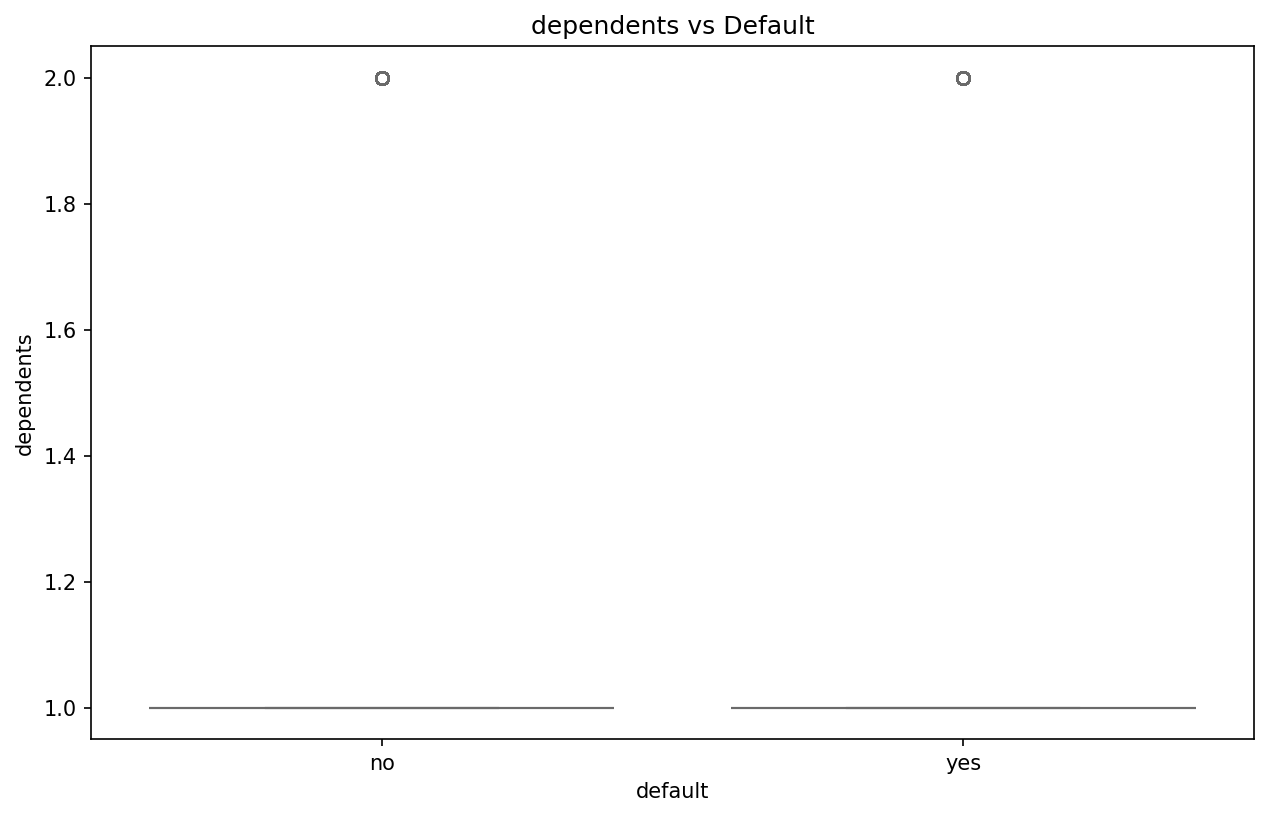

In [ ]:
# Box plots to see the distribution of numerical features against the target variable 'default'
i=1
for feature in numerical_features:
    plt.figure(figsize=(10, 6), dpi=150)
    sns.boxplot(x='default', y=feature, data=df, palette='Set3')
    plt.title(f'{feature} vs Default')
    plt.savefig(f'numericalbox{i}.png',dpi=300)
    plt.show()
    i+=1

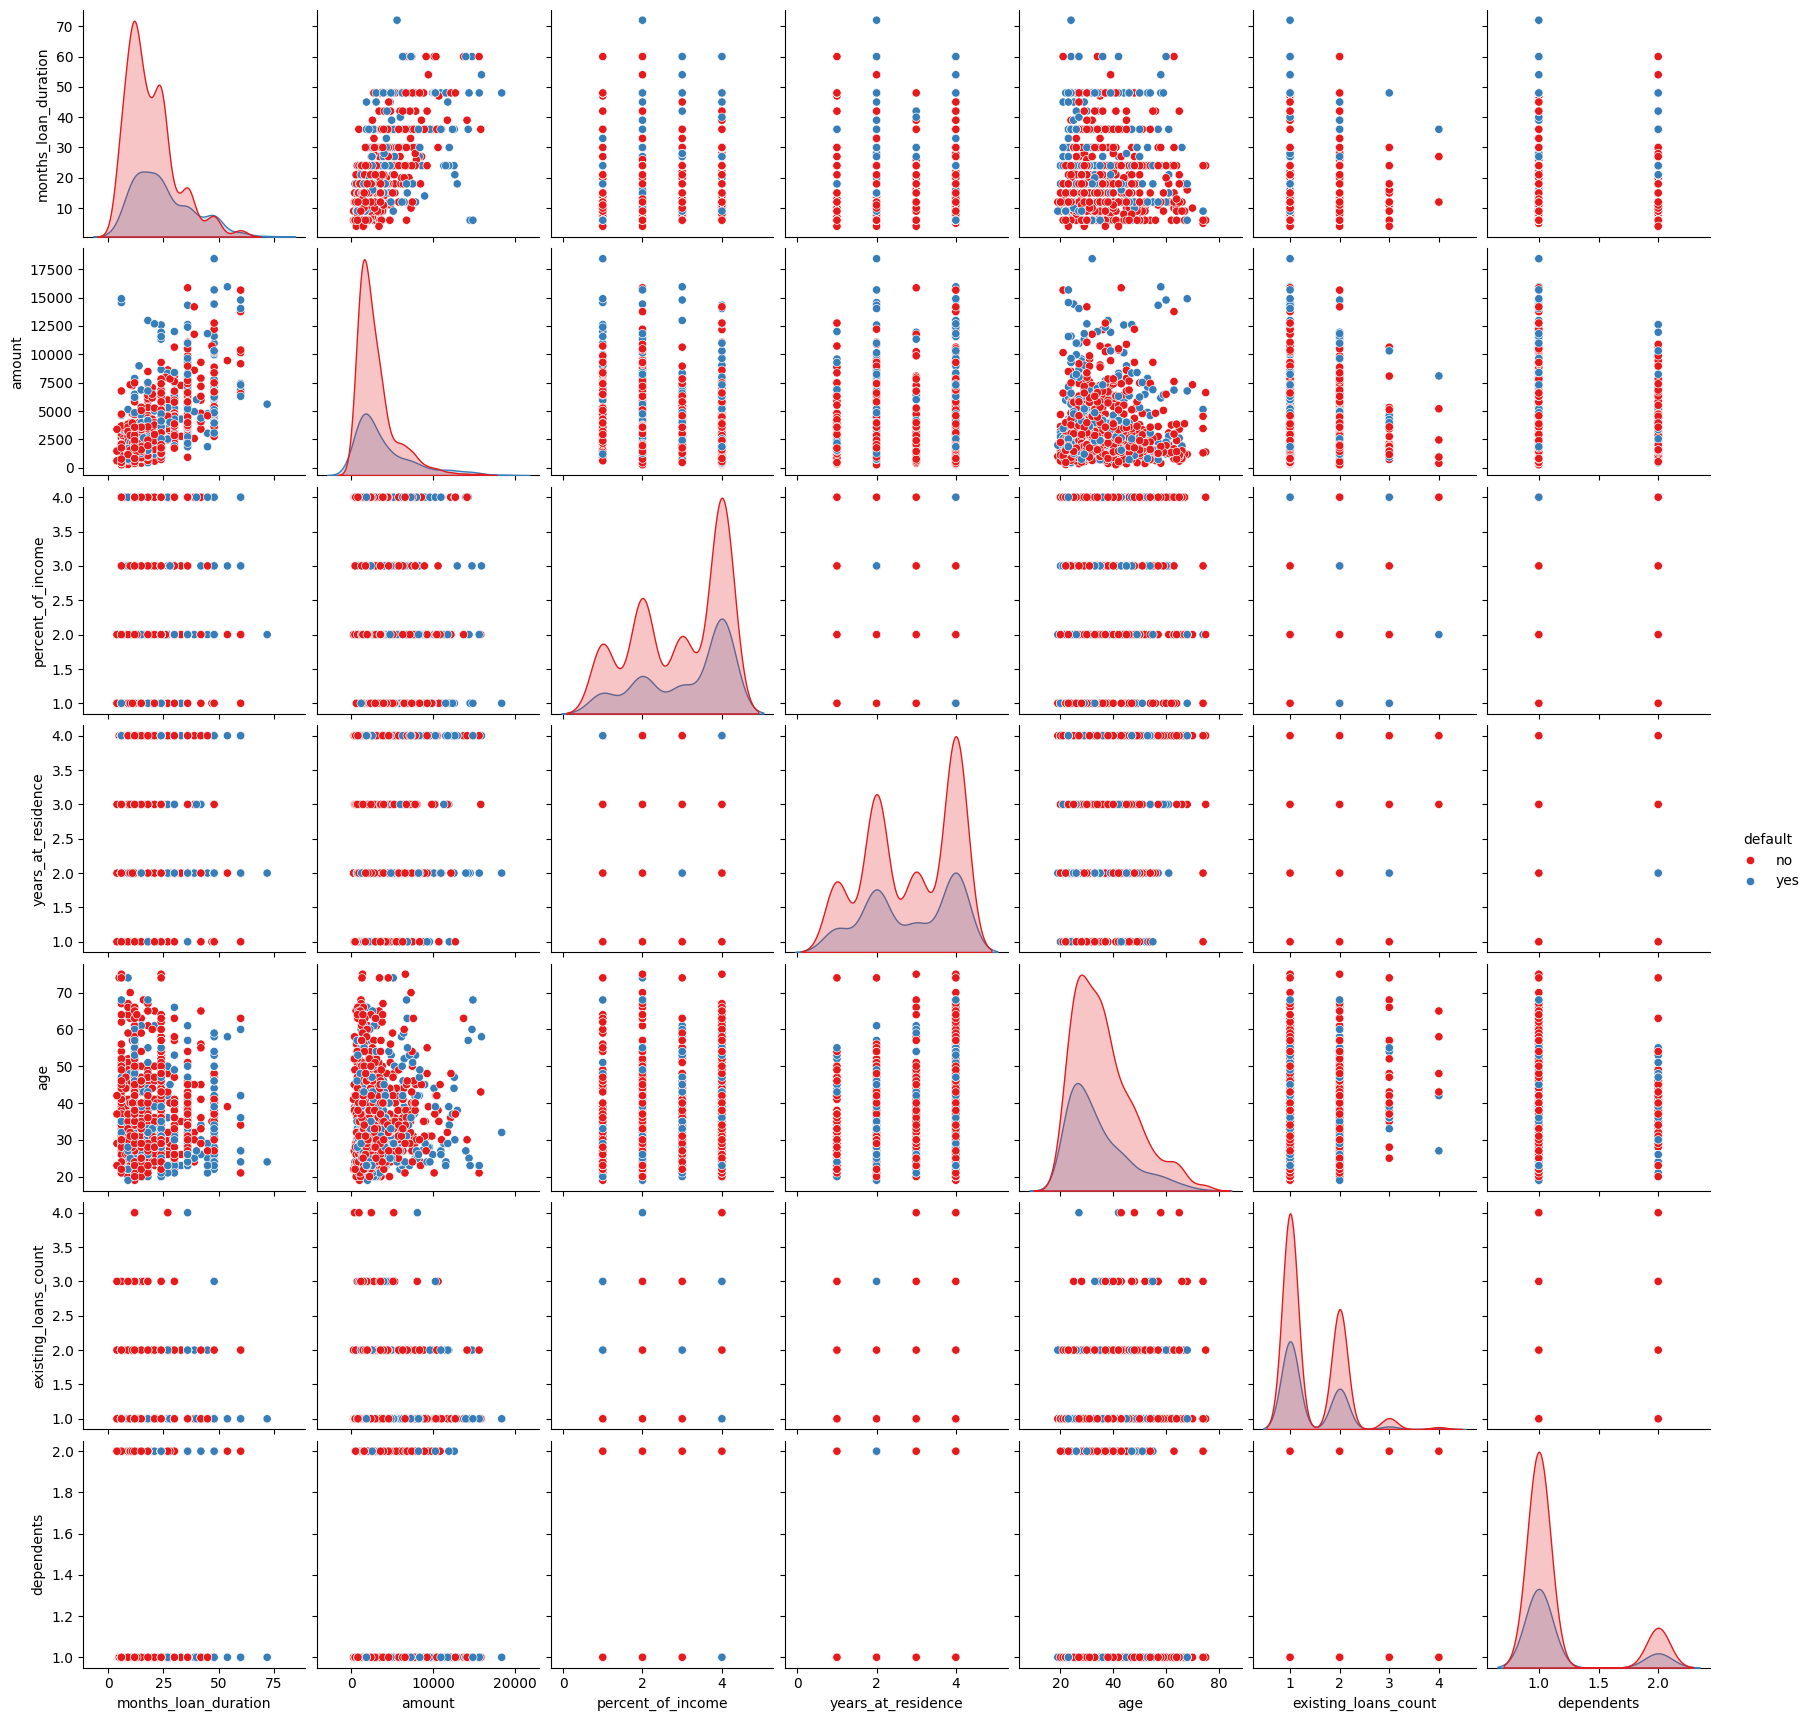

In [ ]:
# Pair plot to visualize relationships between numerical variables
sns.pairplot(df, hue='default', vars=numerical_features, palette='Set1')
plt.savefig('pairplot.png',dpi=300)
plt.show()

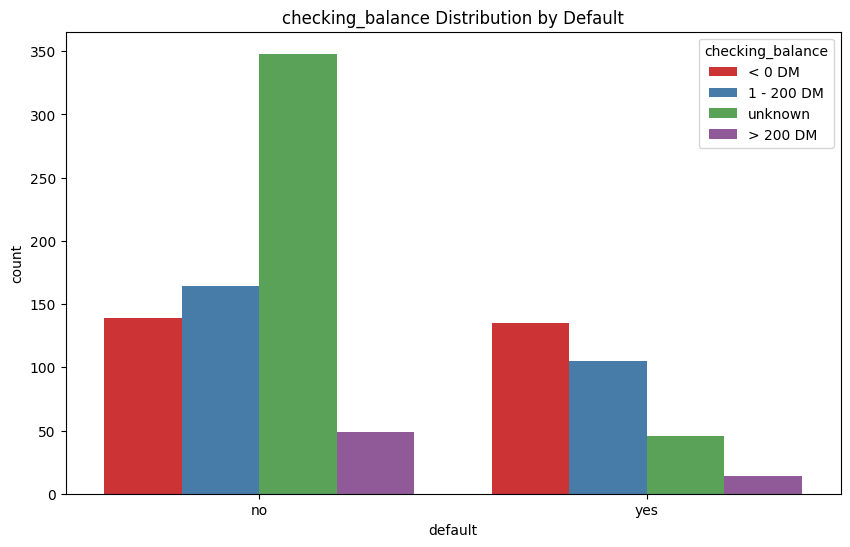

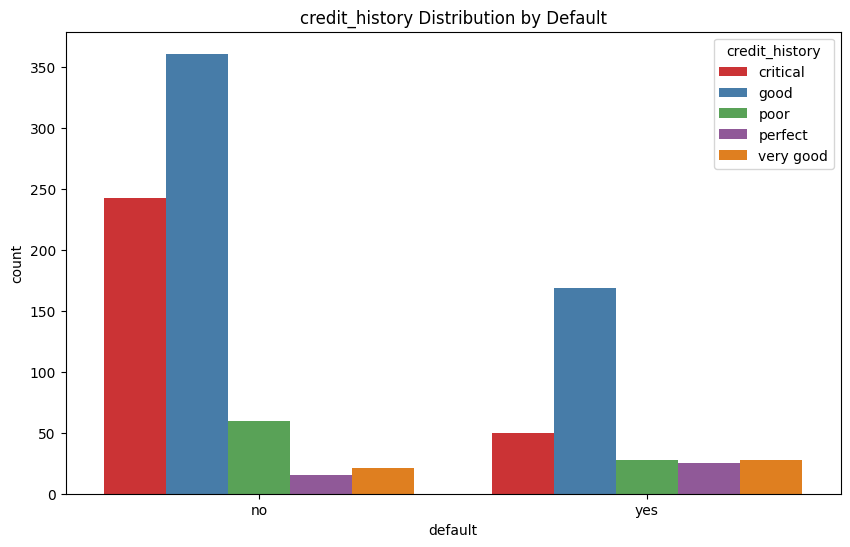

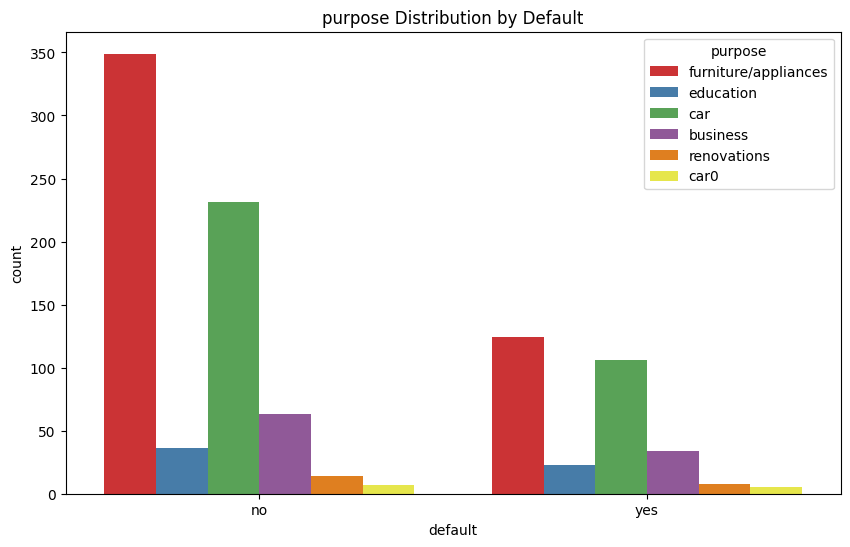

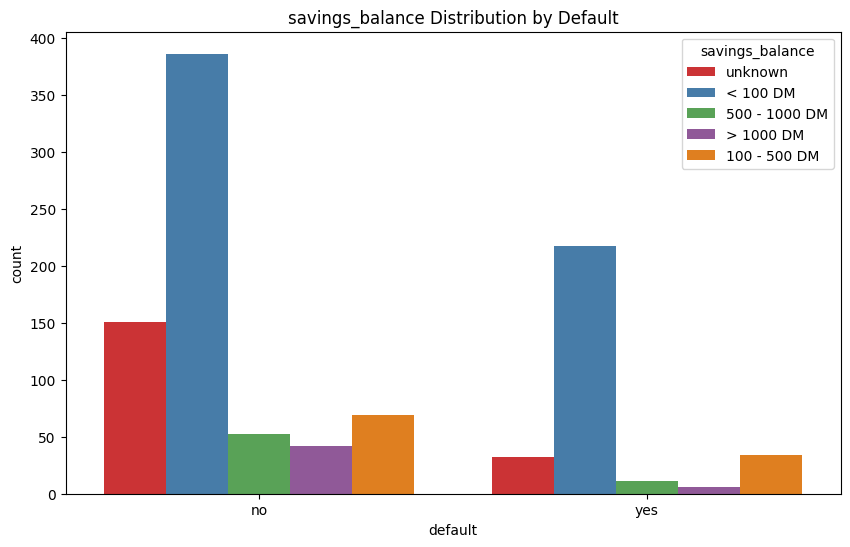

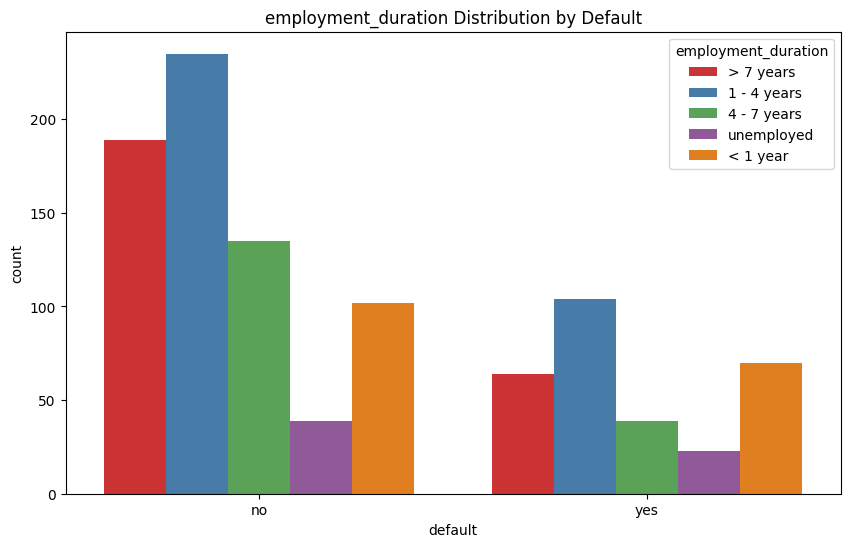

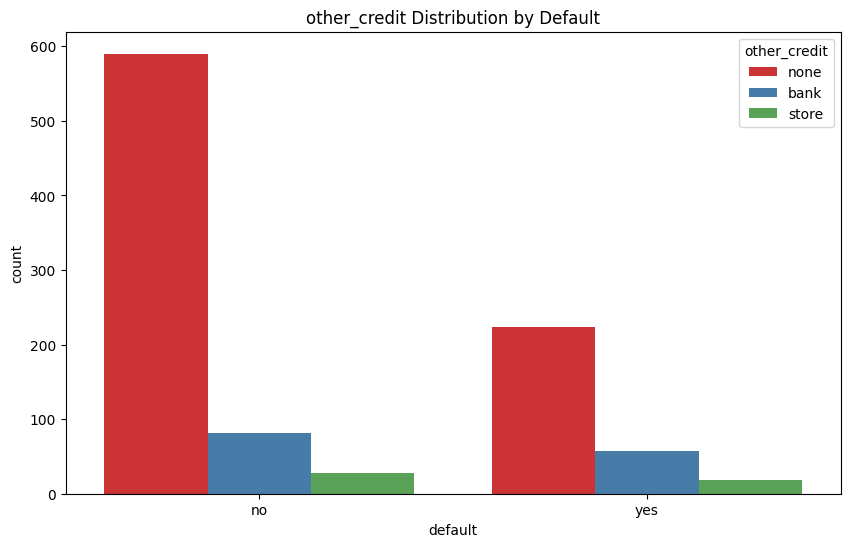

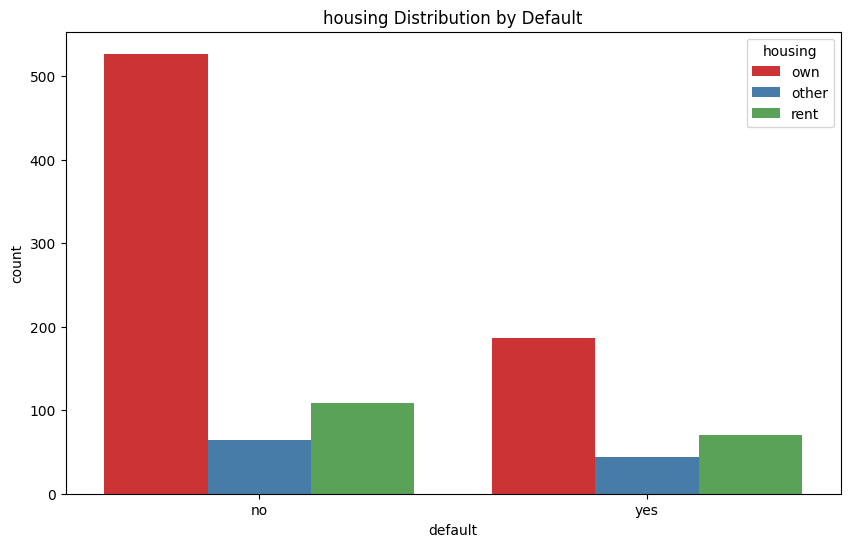

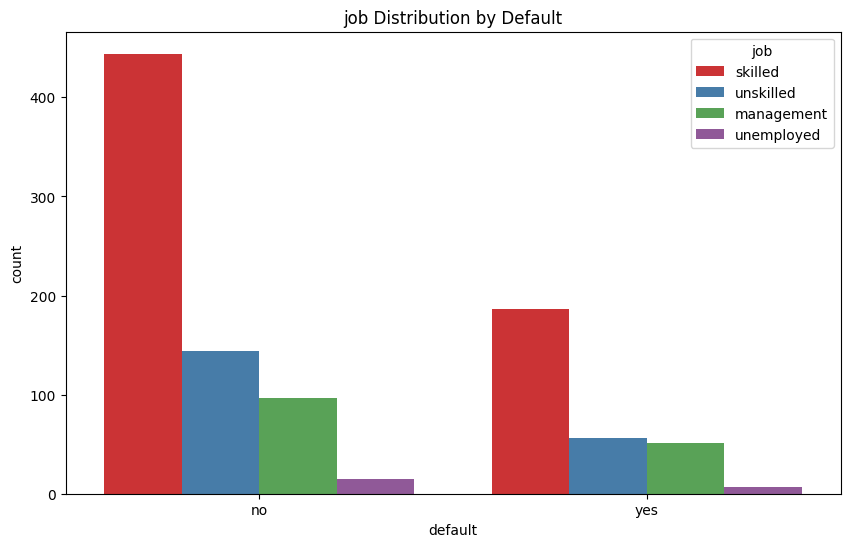

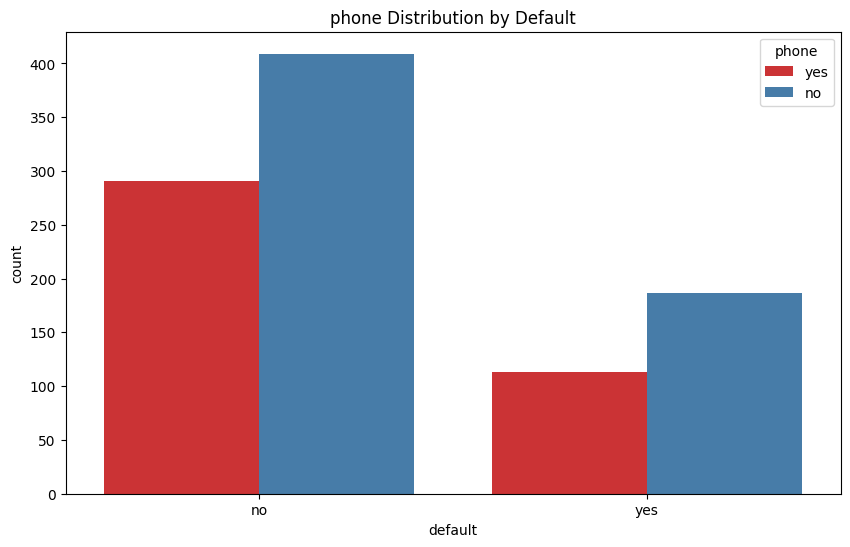

In [ ]:
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='default', hue=feature, data=df, palette='Set1')
    plt.title(f'{feature} Distribution by Default')
    plt.show()

# Data Preprocessing and Feature Selection

In [ ]:
df1=df.copy()

In [ ]:
df1['purpose']=df1['purpose'].replace('car0','car')

In [ ]:
df1.loc[df1['employment_duration'] == 'unemployed', 'job'] = 'unemployed'

In [ ]:
nominal_features=['purpose','other_credit','housing','job','phone','default','checking_balance','savings_balance']
df2=pd.get_dummies(df1,columns=nominal_features, drop_first=True)

In [ ]:
new_names = {'purpose_furniture/appliances': 'purpose_furniture_or_appliances',
             'checking_balance_< 0 DM': 'checking_balance_lessthan 0 DM',
             'checking_balance_> 200 DM': 'checking_balance_lessthan 200 DM',
             'savings_balance_< 100 DM': 'saving_balance_lessthan 100 DM',
             'savings_balance_> 1000 DM': 'saving_balance_morethan 1000 DM',
             }

df2 = df2.rename(columns=new_names)

In [ ]:
employment_duration_mapping = {
    'unemployed': 0,
    '< 1 year': 1,
    '1 - 4 years': 2,
    '4 - 7 years': 3,
    '> 7 years': 4
}
df2['employment_duration_e'] = df2['employment_duration'].map(employment_duration_mapping)
df2 = df2.drop('employment_duration', axis=1)


credit_history_mapping={
    'critical':0,
    'good':1,
    'poor':2,
    'perfect':3,
    'very good':4
}
df2['credit_history_e']=df2['credit_history'].map(credit_history_mapping)
df2=df2.drop('credit_history',axis=1)

In [ ]:
df2.columns

Index(['months_loan_duration', 'amount', 'percent_of_income',
       'years_at_residence', 'age', 'existing_loans_count', 'dependents',
       'purpose_car', 'purpose_education', 'purpose_furniture_or_appliances',
       'purpose_renovations', 'other_credit_none', 'other_credit_store',
       'housing_own', 'housing_rent', 'job_skilled', 'job_unemployed',
       'job_unskilled', 'phone_yes', 'default_yes',
       'checking_balance_lessthan 0 DM', 'checking_balance_lessthan 200 DM',
       'checking_balance_unknown', 'savings_balance_500 - 1000 DM',
       'saving_balance_lessthan 100 DM', 'saving_balance_morethan 1000 DM',
       'savings_balance_unknown', 'employment_duration_e', 'credit_history_e'],
      dtype='object')

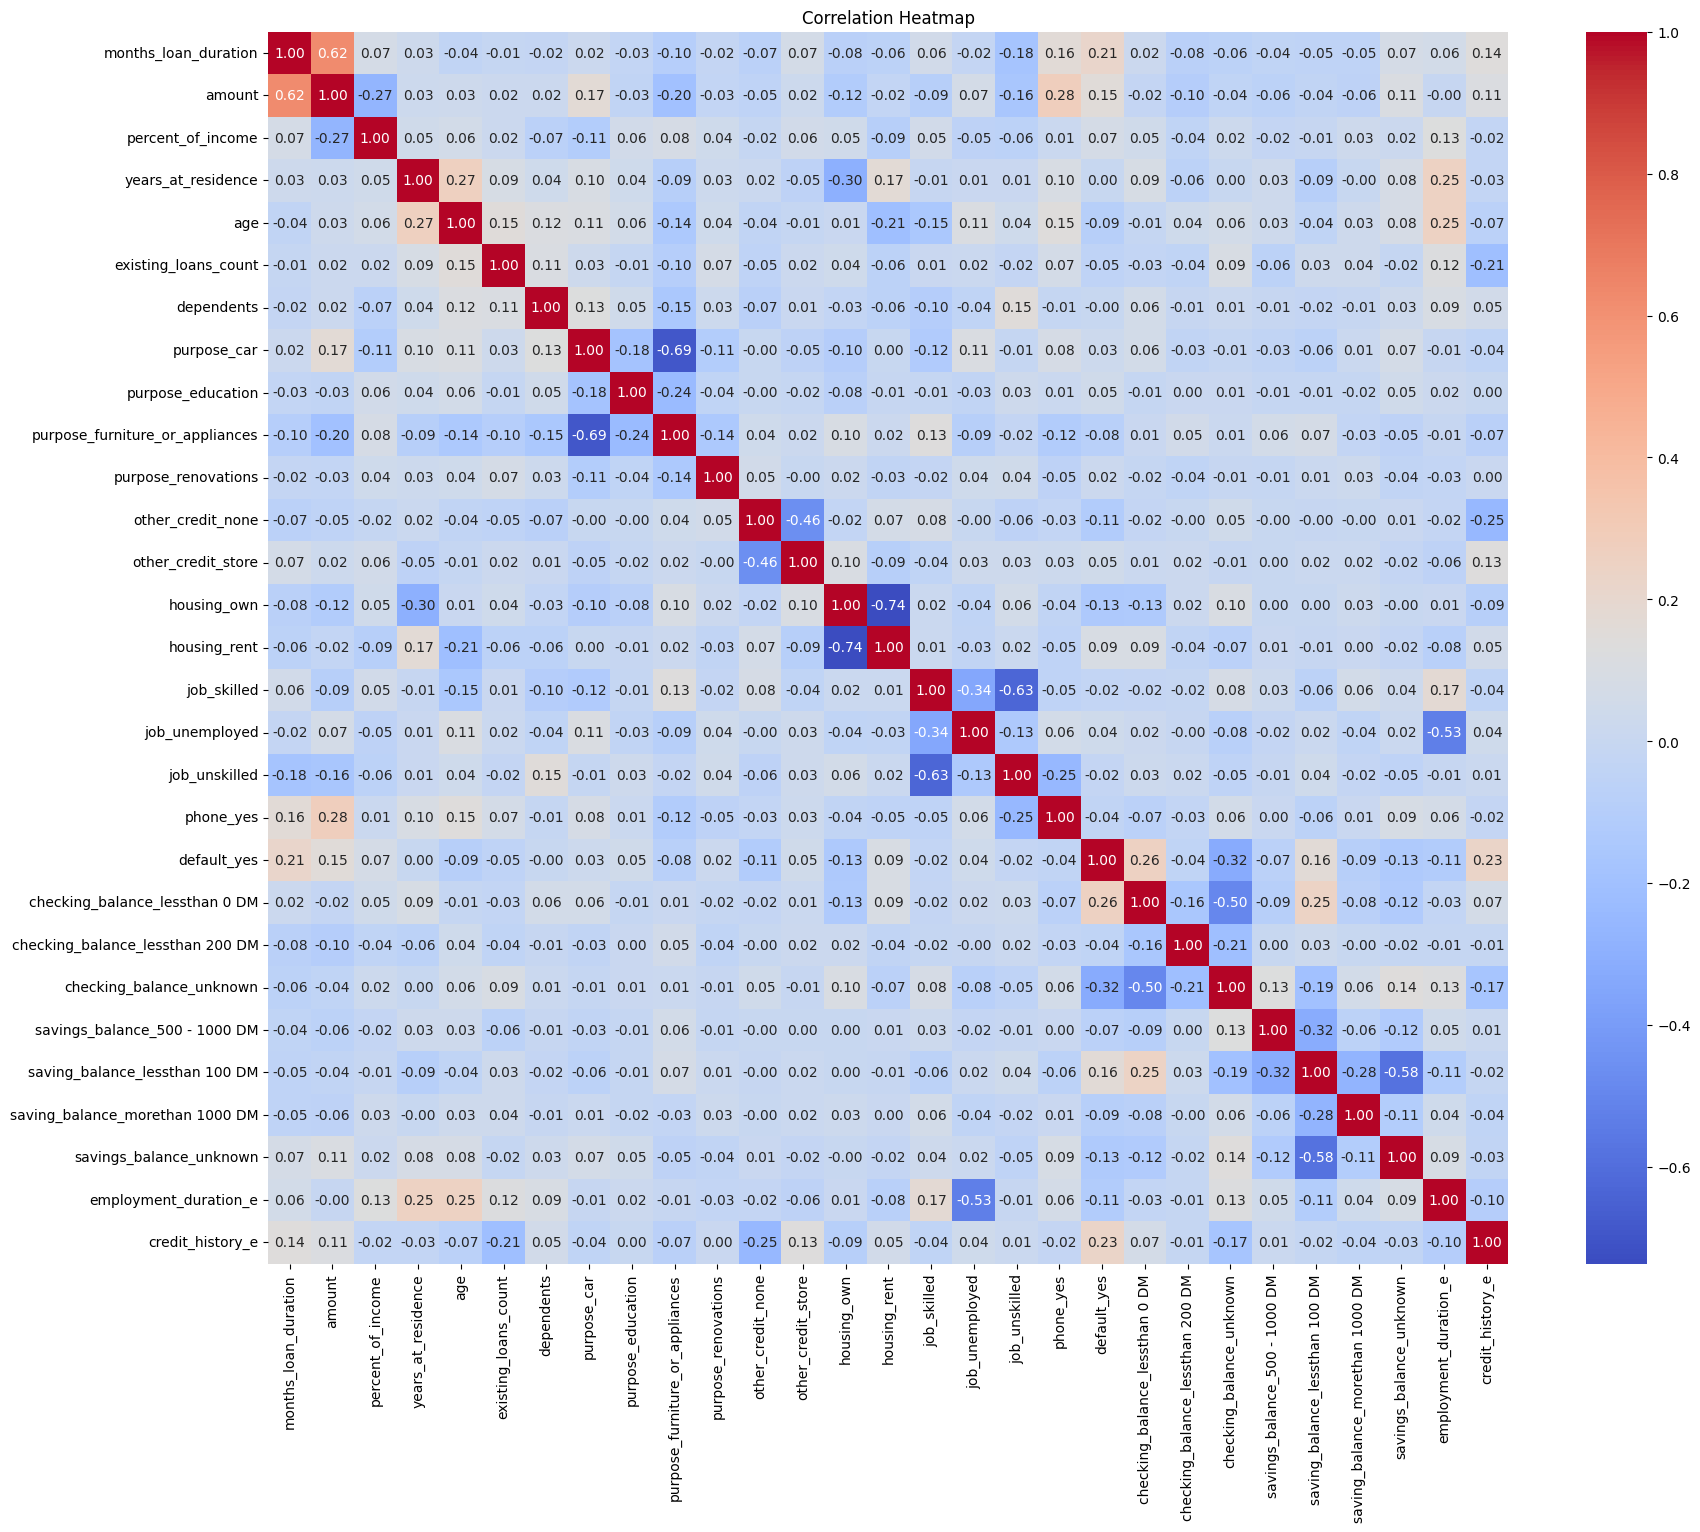

In [ ]:
# Compute the correlation matrix
corr = df2.corr()

# Generate a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png',dpi=300)
plt.show()

In [ ]:
df3=df2.copy()

In [ ]:
X = df3.drop('default_yes', axis=1)
y = df3['default_yes']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Optimal number of features: 20


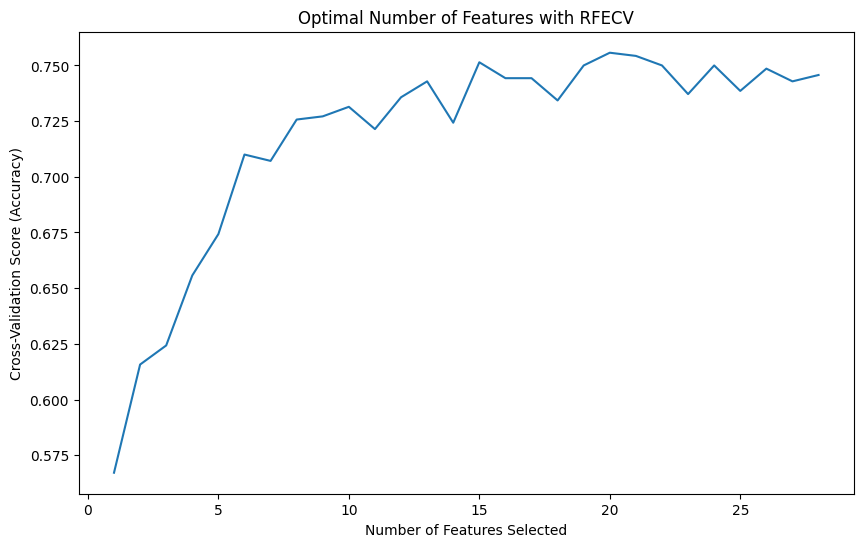

Selected Features: Index(['months_loan_duration', 'amount', 'percent_of_income',
       'years_at_residence', 'age', 'existing_loans_count', 'dependents',
       'purpose_car', 'purpose_education', 'purpose_furniture_or_appliances',
       'other_credit_none', 'housing_own', 'job_skilled', 'phone_yes',
       'checking_balance_lessthan 0 DM', 'checking_balance_unknown',
       'saving_balance_lessthan 100 DM', 'savings_balance_unknown',
       'employment_duration_e', 'credit_history_e'],
      dtype='object')


In [ ]:
rf = RandomForestClassifier(random_state=42)

rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(5), scoring='accuracy')

rfecv.fit(X_train, y_train)

optimal_features = rfecv.n_features_

print(f"Optimal number of features: {optimal_features}")

plt.figure(figsize=(10, 6))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (Accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("Optimal Number of Features with RFECV")
plt.savefig('rfecv.png',dpi=300)
plt.show()

ranking = rfecv.ranking_
selected_features = X_train.columns[rfecv.support_]

print("Selected Features:", selected_features)

In [ ]:
X_train_ = X_train[selected_features]
X_test_ = X_test[selected_features]

# Model training

## Base models

### Logistic Regression

In [ ]:
lr = LogisticRegression()

lr.fit(X_train_, y_train)

y_pred_lr = lr.predict(X_test_)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)

print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_lr)
print("Test Precision:", precision_lr)
print("Test Recall:", recall_lr)
print("Test ROC AUC:", roc_auc_lr)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Random Forest Classifier:
Test Accuracy: 0.7366666666666667
Test Precision: 0.5873015873015873
Test Recall: 0.4111111111111111
Test ROC AUC: 0.6436507936507937



Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.88      0.82       210
        True       0.59      0.41      0.48        90

    accuracy                           0.74       300
   macro avg       0.68      0.64      0.65       300
weighted avg       0.72      0.74      0.72       300

Confusion Matrix:
[[184  26]
 [ 53  37]]


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier()

dt.fit(X_train_, y_train)

y_pred_dt = dt.predict(X_test_)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)

print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_dt)
print("Test Precision:", precision_dt)
print("Test Recall:", recall_dt)
print("Test ROC AUC:", roc_auc_dt)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

Random Forest Classifier:
Test Accuracy: 0.7133333333333334
Test Precision: 0.5212765957446809
Test Recall: 0.5444444444444444
Test ROC AUC: 0.665079365079365



Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.79      0.79       210
        True       0.52      0.54      0.53        90

    accuracy                           0.71       300
   macro avg       0.66      0.67      0.66       300
weighted avg       0.72      0.71      0.72       300

Confusion Matrix:
[[165  45]
 [ 41  49]]


### Random Forest

In [ ]:
rf = RandomForestClassifier()

rf.fit(X_train_, y_train)

y_pred_rf = rf.predict(X_test_)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_rf)
print("Test Precision:", precision_rf)
print("Test Recall:", recall_rf)
print("Test ROC AUC:", roc_auc_rf)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classifier:
Test Accuracy: 0.75
Test Precision: 0.631578947368421
Test Recall: 0.4
Test ROC AUC: 0.65



Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.90      0.83       210
        True       0.63      0.40      0.49        90

    accuracy                           0.75       300
   macro avg       0.70      0.65      0.66       300
weighted avg       0.73      0.75      0.73       300

Confusion Matrix:
[[189  21]
 [ 54  36]]


### XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42,scale_pos_weight=len(y_train[y_train == False])/len(y_train[y_train == True]))

xgb.fit(X_train_, y_train)

y_pred_xgb = xgb.predict(X_test_)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)

print("XG Boost Classifier:")
print("Test Accuracy:", accuracy_xgb)
print("Test Precision:", precision_xgb)
print("Test Recall:", recall_xgb)
print("Test ROC AUC:", roc_auc_xgb)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XG Boost Classifier:
Test Accuracy: 0.7433333333333333
Test Precision: 0.5802469135802469
Test Recall: 0.5222222222222223
Test ROC AUC: 0.6801587301587301



Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.84      0.82       210
        True       0.58      0.52      0.55        90

    accuracy                           0.74       300
   macro avg       0.69      0.68      0.69       300
weighted avg       0.74      0.74      0.74       300

Confusion Matrix:
[[176  34]
 [ 43  47]]


### Gradient Boost

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X_train_, y_train)

y_pred_gbc = gbc.predict(X_test_)

accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
precision_gbc = precision_score(y_test, y_pred_gbc)
recall_gbc = recall_score(y_test, y_pred_gbc)
roc_auc_gbc = roc_auc_score(y_test, y_pred_gbc)

print("Gradient Boost Classifier:")
print("Test Accuracy:", accuracy_gbc)
print("Test Precision:", precision_gbc)
print("Test Recall:", recall_gbc)
print("Test ROC AUC:", roc_auc_gbc)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_gbc))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))


Gradient Boost Classifier:
Test Accuracy: 0.7566666666666667
Test Precision: 0.6197183098591549
Test Recall: 0.4888888888888889
Test ROC AUC: 0.6801587301587302



Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.87      0.83       210
        True       0.62      0.49      0.55        90

    accuracy                           0.76       300
   macro avg       0.71      0.68      0.69       300
weighted avg       0.75      0.76      0.75       300

Confusion Matrix:
[[183  27]
 [ 46  44]]


### KNN Classifier

In [ ]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_, y_train)
y_pred_knn = knn_classifier.predict(X_test_)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)

print("k-Nearest Neighbors (k-NN) Classifier:")
print("Test Accuracy:", accuracy_knn)
print("Test Precision:", precision_knn)
print("Test Recall:", recall_knn)
print("Test ROC AUC:", roc_auc_knn)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

k-Nearest Neighbors (k-NN) Classifier:
Test Accuracy: 0.75
Test Precision: 0.6190476190476191
Test Recall: 0.43333333333333335
Test ROC AUC: 0.6595238095238095



Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.89      0.83       210
        True       0.62      0.43      0.51        90

    accuracy                           0.75       300
   macro avg       0.70      0.66      0.67       300
weighted avg       0.74      0.75      0.74       300

Confusion Matrix:
[[186  24]
 [ 51  39]]


### Naive Bias Classifier

In [ ]:
nb_classifier = GaussianNB()


nb_classifier.fit(X_train_, y_train)

y_pred_nb = nb_classifier.predict(X_test_)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
roc_auc_nb = roc_auc_score(y_test, y_pred_nb)

print("Naive Bayes Classifier:")
print("Test Accuracy:", accuracy_nb)
print("Test Precision:", precision_nb)
print("Test Recall:", recall_nb)
print("Test ROC AUC:", roc_auc_nb)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Naive Bayes Classifier:
Test Accuracy: 0.7066666666666667
Test Precision: 0.5102040816326531
Test Recall: 0.5555555555555556
Test ROC AUC: 0.6634920634920636



Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.77      0.79       210
        True       0.51      0.56      0.53        90

    accuracy                           0.71       300
   macro avg       0.66      0.66      0.66       300
weighted avg       0.71      0.71      0.71       300

Confusion Matrix:
[[162  48]
 [ 40  50]]


### LightGBM

In [ ]:
lgb = lgb.LGBMClassifier(class_weight='balanced')

lgb.fit(X_train_, y_train)

y_pred_lgb = lgb.predict(X_test_)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_pred_lgb)

print("Naive Bayes Classifier:")
print("Test Accuracy:", accuracy_lgb)
print("Test Precision:", precision_lgb)
print("Test Recall:", recall_lgb)
print("Test ROC AUC:", roc_auc_lgb)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 210, number of negative: 490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

## Penalty for minority

### Logistic Regression

In [ ]:
class_weights = {False: 1, True: 3}
lrb = LogisticRegression(class_weight=class_weights)

lrb.fit(X_train_, y_train)

y_pred_lr = lrb.predict(X_test_)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)

print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_lr)
print("Test Precision:", precision_lr)
print("Test Recall:", recall_lr)
print("Test ROC AUC:", roc_auc_lr)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Random Forest Classifier:
Test Accuracy: 0.67
Test Precision: 0.47058823529411764
Test Recall: 0.8
Test ROC AUC: 0.7071428571428573



Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.61      0.72       210
        True       0.47      0.80      0.59        90

    accuracy                           0.67       300
   macro avg       0.67      0.71      0.66       300
weighted avg       0.76      0.67      0.68       300

Confusion Matrix:
[[129  81]
 [ 18  72]]


### Decision Tree

In [ ]:
class_weights = {False: 1, True: 3}
dt_p = DecisionTreeClassifier(class_weight=class_weights)

dt_p.fit(X_train_, y_train)

y_pred_dtp = dt.predict(X_test_)
accuracy_dtp = accuracy_score(y_test, y_pred_dtp)
precision_dtp = precision_score(y_test, y_pred_dtp)
recall_dtp = recall_score(y_test, y_pred_dtp)
roc_auc_dtp = roc_auc_score(y_test, y_pred_dtp)

print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_dtp)
print("Test Precision:", precision_dtp)
print("Test Recall:", recall_dtp)
print("Test ROC AUC:", roc_auc_dtp)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_dtp))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dtp))

Random Forest Classifier:
Test Accuracy: 0.7133333333333334
Test Precision: 0.5212765957446809
Test Recall: 0.5444444444444444
Test ROC AUC: 0.665079365079365



Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.79      0.79       210
        True       0.52      0.54      0.53        90

    accuracy                           0.71       300
   macro avg       0.66      0.67      0.66       300
weighted avg       0.72      0.71      0.72       300

Confusion Matrix:
[[165  45]
 [ 41  49]]


### Random Forest

In [ ]:
rfp = RandomForestClassifier()

rfp.fit(X_train_, y_train)

y_pred_rfp = rfp.predict(X_test_)
accuracy_rfp = accuracy_score(y_test, y_pred_rfp)
precision_rfp = precision_score(y_test, y_pred_rfp)
recall_rfp = recall_score(y_test, y_pred_rfp)
roc_auc_rfp = roc_auc_score(y_test, y_pred_rfp)

print("Random Forest Classifier:")
print("Test Accuracy:", accuracy_rfp)
print("Test Precision:", precision_rfp)
print("Test Recall:", recall_rfp)
print("Test ROC AUC:", roc_auc_rfp)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_rfp))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfp))

Random Forest Classifier:
Test Accuracy: 0.7566666666666667
Test Precision: 0.6491228070175439
Test Recall: 0.4111111111111111
Test ROC AUC: 0.6579365079365079



Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.90      0.84       210
        True       0.65      0.41      0.50        90

    accuracy                           0.76       300
   macro avg       0.72      0.66      0.67       300
weighted avg       0.74      0.76      0.74       300

Confusion Matrix:
[[190  20]
 [ 53  37]]


## Anamoly detection

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

y_train_anomaly = y_train.apply(lambda x: 1 if x == True else -1)
y_test_anomaly = y_test.apply(lambda x: 1 if x == True else -1)

iso_forest = IsolationForest(contamination=len(y_train_anomaly[y_train_anomaly == 1]) / len(y_train_anomaly), random_state=42)
iso_forest.fit(X_train_)

y_pred_iso = iso_forest.predict(X_test_)

y_pred_iso = [True if pred == -1 else False for pred in y_pred_iso]

print("Isolation Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))

print("\nIsolation Forest Classification Report:")
print(classification_report(y_test, y_pred_iso))


Isolation Forest Confusion Matrix:
[[140  70]
 [ 56  34]]

Isolation Forest Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.67      0.69       210
        True       0.33      0.38      0.35        90

    accuracy                           0.58       300
   macro avg       0.52      0.52      0.52       300
weighted avg       0.60      0.58      0.59       300



In [ ]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel='rbf', nu=0.05, gamma='auto')
ocsvm.fit(X_train_[y_train_anomaly == -1])

y_pred_svm = ocsvm.predict(X_test_)


y_pred_svm = [True if pred == -1 else False for pred in y_pred_svm]


print("One-Class SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nOne-Class SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


One-Class SVM Confusion Matrix:
[[177  33]
 [ 72  18]]

One-Class SVM Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.84      0.77       210
        True       0.35      0.20      0.26        90

    accuracy                           0.65       300
   macro avg       0.53      0.52      0.51       300
weighted avg       0.60      0.65      0.62       300



## Hyperparameter Tuning

### RandomForest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300,400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train_, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_

y_pred_rf_ht = best_rf.predict(X_test_)
accuracy_rf_ht = accuracy_score(y_test, y_pred_rf_ht)
precision_rf_ht = precision_score(y_test, y_pred_rf_ht)
recall_rf_ht = recall_score(y_test, y_pred_rf_ht)
roc_auc_rf_ht = roc_auc_score(y_test, y_pred_rf_ht)

print("Random Forest Classifier after Hyperparameter tuning:")
print("Test Accuracy:", accuracy_rf_ht)
print("Test Precision:", precision_rf_ht)
print("Test Recall:", recall_rf_ht)
print("Test ROC AUC:", roc_auc_rf_ht)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_ht))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_ht))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Classifier after Hyperparameter tuning:
Test Accuracy: 0.7633333333333333
Test Precision: 0.6666666666666666
Test Recall: 0.4222222222222222
Test ROC AUC: 0.6658730158730158



Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.91      0.84       210
        True       0.67      0.42      0.52        90

    accuracy                           0.76       300
   macro avg       0.73      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300

Confusion Matrix:
[[191  19]
 [ 52  38]]


### XGBoost

In [ ]:
param_grid = {
    'max_depth': [5, 8, 12, 16],
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'eta': [0.1, 0.3, 0.5]
}

xgb_model = XGBClassifier(random_state=42, scale_pos_weight=1)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_, y_train)

best_xgb = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)
y_pred_xgb_ht = best_xgb.predict(X_test_)
accuracy_xgb_ht = accuracy_score(y_test, y_pred_xgb_ht)
precision_xgb_ht = precision_score(y_test, y_pred_xgb_ht)
recall_xgb_ht = recall_score(y_test, y_pred_xgb_ht)
roc_auc_xgb_ht = roc_auc_score(y_test, y_pred_xgb_ht)

print("XGBoost Classifier after Hyperparameter tuning:")
print("Test Accuracy:", accuracy_xgb_ht)
print("Test Precision:", precision_xgb_ht)
print("Test Recall:", recall_xgb_ht)
print("Test ROC AUC:", roc_auc_xgb_ht)

print("\n\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_ht))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_ht))

Best Hyperparameters: {'eta': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300}
XGBoost Classifier after Hyperparameter tuning:
Test Accuracy: 0.73
Test Precision: 0.5789473684210527
Test Recall: 0.36666666666666664
Test ROC AUC: 0.6261904761904762



Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.89      0.82       210
        True       0.58      0.37      0.45        90

    accuracy                           0.73       300
   macro avg       0.67      0.63      0.64       300
weighted avg       0.71      0.73      0.71       300

Confusion Matrix:
[[186  24]
 [ 57  33]]


## Models performance evaluation

In [ ]:
classifiers = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'Gradient Boost': gbc,
    'XGBoost': xgb,
    'k-NN': knn_classifier,
    'Naive Bayes': nb_classifier,
    'Light GBM': lgb,
    'Random Forest after tuning': best_rf,
    'XGBoost after tuning': best_xgb,
}
num_classifiers = len(classifiers)

### ROC

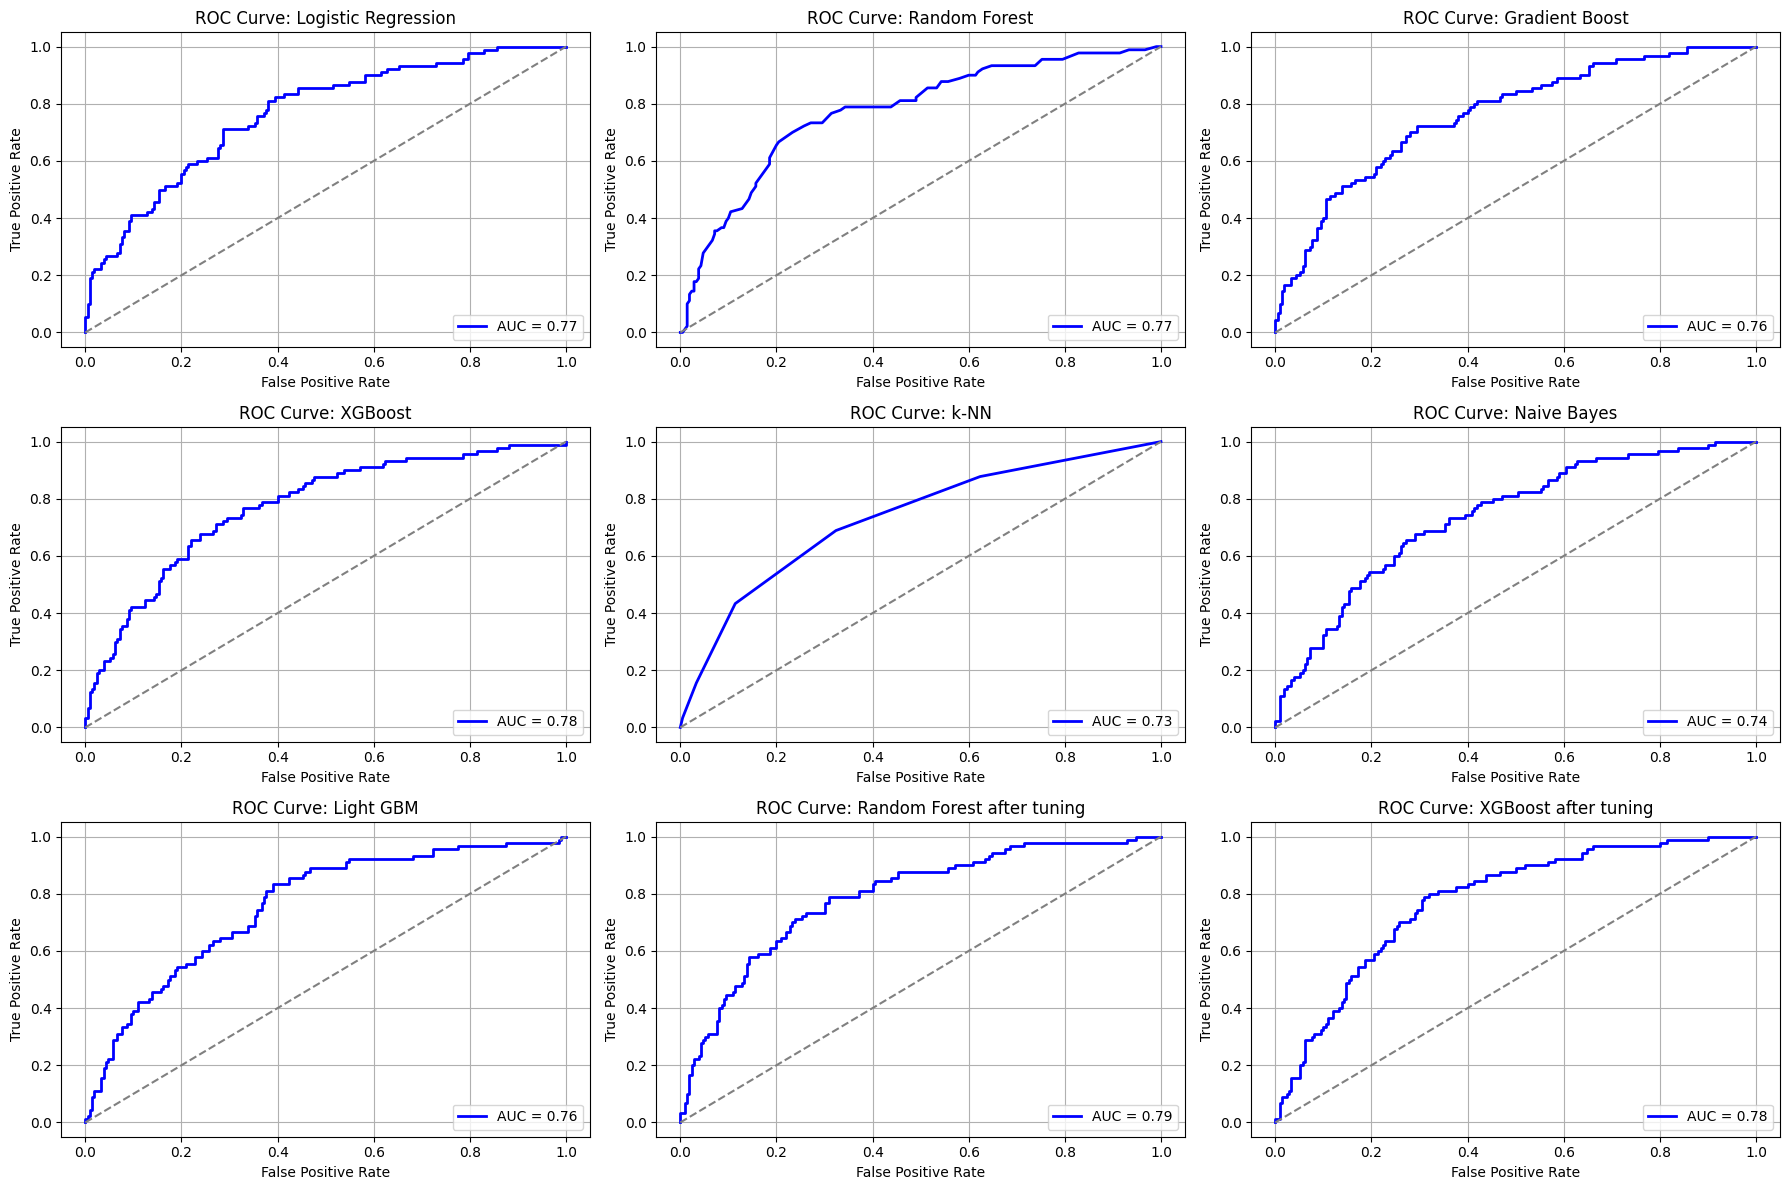

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

# Generate ROC curves for each classifier
for i, (clf_name, clf) in enumerate(classifiers.items()):
    y_prob = clf.predict_proba(X_test_)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Plotting on the corresponding subplot
    axes[i].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='b', lw=2)
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[i].set_title(f'ROC Curve: {clf_name}')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc='lower right')
    axes[i].grid(True)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

### Precision Recall curve

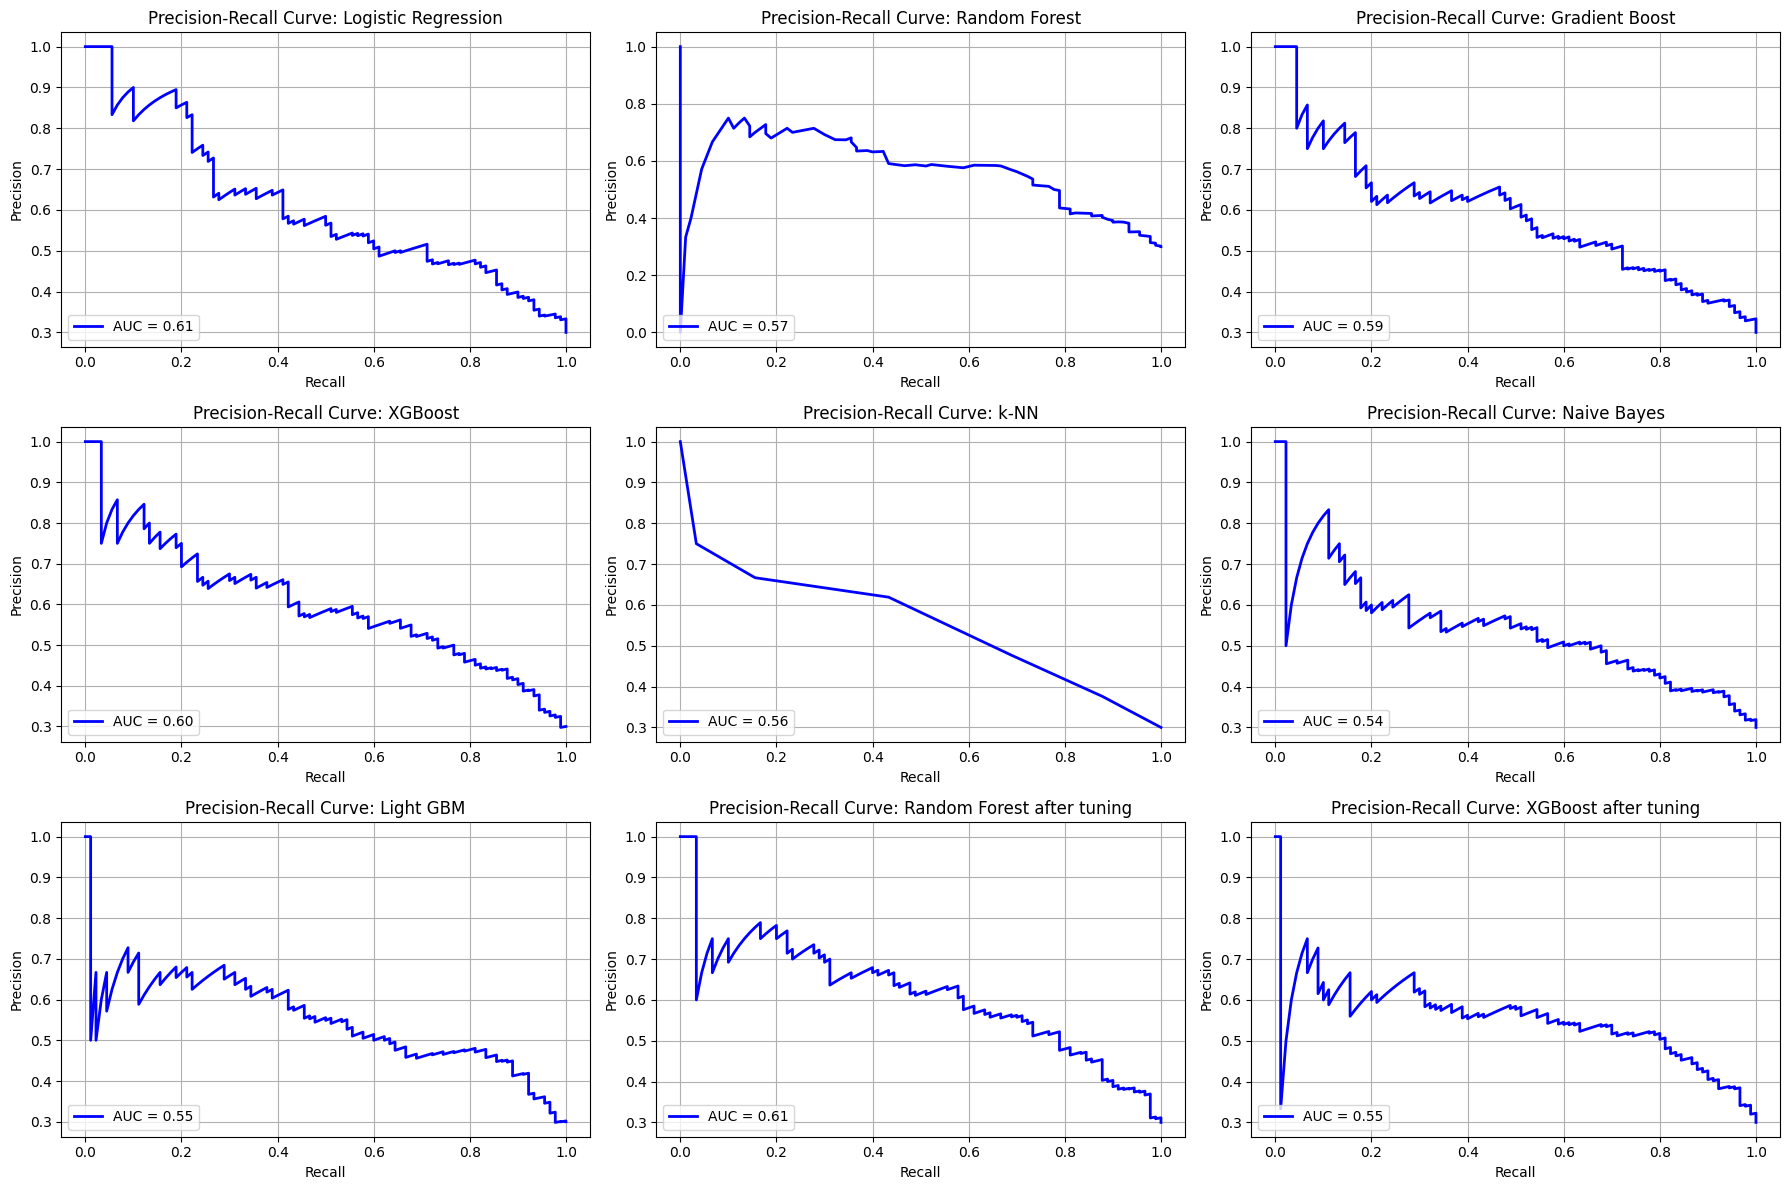

In [ ]:

# Determine grid size based on the number of classifiers
rows = (num_classifiers // 3) + (num_classifiers % 3 > 0)
cols = 3

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

# Generate Precision-Recall curves for each classifier
for i, (clf_name, clf) in enumerate(classifiers.items()):
    y_prob = clf.predict_proba(X_test_)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    # Plotting on the corresponding subplot
    axes[i].plot(recall, precision, label=f'AUC = {pr_auc:.2f}', color='b', lw=2)
    axes[i].set_title(f'Precision-Recall Curve: {clf_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].legend(loc='lower left')
    axes[i].grid(True)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300)
plt.show()

### DF

In [ ]:
models = ['Logistic Regression','Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost','KNN Classifier','Naive Bias','LightGBM']

# Accuracy values
accuracies = [accuracy_lr,accuracy_dt, accuracy_rf, accuracy_gbc, accuracy_xgb,accuracy_knn, accuracy_nb,accuracy_lgb]

# Precision values
precisions = [precision_lr, precision_dt, precision_rf, precision_gbc, precision_xgb, precision_knn,precision_nb,precision_lgb]

# Recall values
recalls = [recall_lr,recall_dt, recall_rf, recall_gbc, recall_xgb,recall_knn,recall_nb,recall_lgb]

# ROC AUC values
roc_aucs = [roc_auc_lr,roc_auc_dt, roc_auc_rf, roc_auc_gbc, roc_auc_xgb,roc_auc_knn,roc_auc_nb,roc_auc_lgb]

performance_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'ROC AUC':roc_aucs
})

performance_df.sort_values(by='Accuracy', ascending=False, inplace=True)

performance_df


,Model,Accuracy,Precision,Recall,ROC AUC
3,Gradient Boosting,0.756667,0.619718,0.488889,0.680159
2,Random Forest,0.750000,0.631579,0.400000,0.650000
5,KNN Classifier,0.750000,0.619048,0.433333,0.659524
4,XGBoost,0.743333,0.580247,0.522222,0.680159
7,LightGBM,0.726667,0.544444,0.544444,0.674603
1,Decision Tree,0.713333,0.521277,0.544444,0.665079
6,Naive Bias,0.706667,0.510204,0.555556,0.663492
0,Logistic Regression,0.670000,0.470588,0.800000,0.707143


In [ ]:
performance_df.to_excel('output.xlsx', index=False)

# Conclusion and Remarks

Among the models evaluated, Gradient Boosting achieved the highest accuracy (0.76) and ROC AUC (0.68), indicating its strong overall performance. Logistic Regression, despite having the lowest accuracy (0.67), demonstrated the highest recall (0.80), showing its ability to capture more positive instances. XGBoost and LightGBM showed competitive results, making them viable alternatives, though their precision and recall varied slightly.